In [1]:
import string
import numpy as np
from PIL import Image
import os
from pickle import dump, load
import numpy as np

from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers.merge import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout

# small library for seeing the progress of loops.
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

Using TensorFlow backend.


C:\ProgramData\Anaconda3\lib\site-packages\tqdm\std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
# Loading a text file into memory
def load_doc(filename):
    # Opening the file as read only
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

In [3]:
# get all imgs with their captions
def all_img_captions(filename):
    file = load_doc(filename)
    captions = file.split('\n')
    descriptions ={}
    for caption in captions[:-1]:
        img, caption = caption.split('\t')
        if img[:-2] not in descriptions:
            descriptions[img[:-2]] = [caption]
        else:
            descriptions[img[:-2]].append(caption)
    return descriptions

In [4]:
##Data cleaning- lower casing, removing puntuations and words containing numbers
def cleaning_text(captions):
    table = str.maketrans('','',string.punctuation)
    for img,caps in captions.items():
        for i,img_caption in enumerate(caps):

            img_caption.replace("-"," ")
            desc = img_caption.split()

            #converts to lower case
            desc = [word.lower() for word in desc]
            #remove punctuation from each token
            desc = [word.translate(table) for word in desc]
            #remove hanging 's and a 
            desc = [word for word in desc if(len(word)>1)]
            #remove tokens with numbers in them
            desc = [word for word in desc if(word.isalpha())]
            #convert back to string

            img_caption = ' '.join(desc)
            captions[img][i]= img_caption
    return captions

In [5]:
def text_vocabulary(descriptions):
    # build vocabulary of all unique words
    vocab = set()
    
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    
    return vocab

In [6]:
#All descriptions in one file 
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()

In [7]:
# all_train_captions = []
# for key, val in descriptions.items():
#     for cap in val:
#         all_train_captions.append(cap)

# # Consider only words which occur at least 8 times in the corpus
# word_count_threshold = 8
# word_counts = {}
# nsents = 0
# for sent in all_train_captions:
#     nsents += 1
#     for w in sent.split(' '):
#         word_counts[w] = word_counts.get(w, 0) + 1

# vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

# print('preprocessed words %d ' % len(vocab))


In [8]:
dataset_text = "D:\Image Caption Generator"
#dataset_images = "D:\dataflair projects\Project - Image Caption Generator\Flicker8k_Dataset"

In [9]:
#we prepare our text data
filename = dataset_text + "/" + "Flickr8k.token.txt"
#loading the file that contains all data
#mapping them into descriptions dictionary img to 5 captions
descriptions = all_img_captions(filename)
print("Length of descriptions =" ,len(descriptions))

#cleaning the descriptions
clean_descriptions = cleaning_text(descriptions)
#building vocabulary 
vocabulary = text_vocabulary(clean_descriptions)
print("Length of vocabulary = ", len(vocabulary))

#saving each description to file 
#save_descriptions(clean_descriptions, "descriptions.txt")

ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:

def extract_features(directory):
        model = Xception( include_top=False, pooling='avg' )
        features = {}
        for img in tqdm(os.listdir(directory)):
            filename = directory + "/" + img
            image = Image.open(filename)
            image = image.resize((299,299))
            image = np.expand_dims(image, axis=0)
            #image = preprocess_input(image)
            image = image/127.5
            image = image - 1.0
            
            feature = model.predict(image)
            features[img] = feature
        return features

In [10]:
#2048 feature vector
#features = extract_features(dataset_images)
#dump(features, open("features.p","wb"))

In [12]:
features = load(open("features.p","rb"))

In [13]:
#load the data 
def load_photos(filename):
    file = load_doc(filename)
    photos = file.split("\n")[:-1]
    return photos


def load_clean_descriptions(filename, photos):   
    #loading clean_descriptions
    file = load_doc(filename)
    descriptions = {}
    for line in file.split("\n"):
        
        words = line.split()
        if len(words)<1 :
            continue
    
        image, image_caption = words[0], words[1:]
        
        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = '<start> ' + " ".join(image_caption) + ' <end>'
            descriptions[image].append(desc)

    return descriptions


def load_features(photos):
    #loading all features
    #all_features = load(open("features.p","rb"))
    #selecting only needed features
    features1 = {k:features[k] for k in photos}
    return features1


In [14]:
def getList(dict): 
    return dict.keys() 
train_imgs=getList( features)

In [15]:
#filename = dataset_text + "/" + "Flickr8k.token.txt"

#train = loading_data(filename)
#train_imgs = load_photos(filename)
train_descriptions = load_clean_descriptions("descriptions.txt", train_imgs)

In [16]:
train_features = load_features(train_imgs)

In [17]:
#converting dictionary to clean list of descriptions
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

#creating tokenizer class 
#this will vectorise text corpus
#each integer will represent token in dictionary 

from keras.preprocessing.text import Tokenizer

def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer


In [18]:
# give each word a index, and store that into tokenizer.p pickle file
#tokenizer = create_tokenizer(train_descriptions)
tokenizer=load(open('tokenizer.p', 'rb'))
#dump(tokenizer, open('tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
vocab_size 

7577

In [19]:
#calculate maximum length of descriptions
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)

max_length = max_length(descriptions)
max_length

32

In [20]:
features['1000268201_693b08cb0e.jpg'][0]

array([0.36452794, 0.12713662, 0.0013574 , ..., 0.221817  , 0.01178991,
       0.24176797], dtype=float32)

In [21]:
# Define the model

#1 Photo feature extractor - we extracted features from pretrained model Xception. 
#2 Sequence processor - word embedding layer that handles text, followed by LSTM 
#3 Decoder - Both 1 and 2 model produce fixed length vector. They are merged together and processed by dense layer to make final prediction

In [11]:
#create input-output sequence pairs from the image description.

#data generator, used by model.fit_generator()
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield [[input_image, input_sequence], output_word]         

def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

In [12]:
[a,b],c = next(data_generator(train_descriptions, features, tokenizer, max_length))
a.shape, b.shape, c.shape

NameError: name 'train_descriptions' is not defined

In [24]:
from keras.utils import plot_model

# define the captioning model
def define_model(vocab_size, max_length):
    
    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    # summarize model
    print(model.summary())
    #plot_model(model, to_file='model.png', show_shapes=True)
    
    return model

In [135]:
# train our model
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

model = define_model(vocab_size, max_length)
epochs = 10
steps = len(train_descriptions)
# making a directory models to save our models
#os.mkdir("models")
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)
    model.save("models/model_" + str(i) + ".h5")

Dataset:  8091
Descriptions: train= 8091
Photos: train= 8091
Vocabulary Size: 7577
Description Length:  32
Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_38 (InputLayer)           (None, 32)           0                                            
__________________________________________________________________________________________________
input_37 (InputLayer)           (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 32, 256)      1939712     input_38[0][0]                   
__________________________________________________________________________________________________
dropout_19 (Dropout)            (None, 2048)         0           input_37[0][0]    

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1


 313/8091 [>.............................] - ETA: 2:23:33 - loss: 8.93 - ETA: 1:30:15 - loss: 8.92 - ETA: 1:15:56 - loss: 8.89 - ETA: 1:06:47 - loss: 8.88 - ETA: 1:00:10 - loss: 8.86 - ETA: 55:06 - loss: 8.8169 - ETA: 52:43 - loss: 8.75 - ETA: 50:53 - loss: 8.70 - ETA: 49:44 - loss: 8.59 - ETA: 47:58 - loss: 8.51 - ETA: 46:48 - loss: 8.41 - ETA: 46:09 - loss: 8.31 - ETA: 46:09 - loss: 8.24 - ETA: 45:04 - loss: 8.10 - ETA: 45:05 - loss: 8.02 - ETA: 44:20 - loss: 7.90 - ETA: 44:02 - loss: 7.84 - ETA: 43:44 - loss: 7.83 - ETA: 43:34 - loss: 7.71 - ETA: 43:09 - loss: 7.65 - ETA: 42:38 - loss: 7.58 - ETA: 42:15 - loss: 7.55 - ETA: 42:00 - loss: 7.47 - ETA: 41:30 - loss: 7.44 - ETA: 41:29 - loss: 7.37 - ETA: 41:12 - loss: 7.37 - ETA: 41:13 - loss: 7.32 - ETA: 41:05 - loss: 7.30 - ETA: 40:44 - loss: 7.31 - ETA: 40:23 - loss: 7.25 - ETA: 40:02 - loss: 7.24 - ETA: 39:48 - loss: 7.24 - ETA: 39:36 - loss: 7.22 - ETA: 39:37 - loss: 7.19 - ETA: 39:28 - loss: 7.17 - ETA: 39:19 - loss: 7.14 - ETA: 39

6907/8091 [========================>.....] - ETA: 9:19 - loss: 4.439 - ETA: 9:19 - loss: 4.439 - ETA: 9:19 - loss: 4.439 - ETA: 9:18 - loss: 4.439 - ETA: 9:18 - loss: 4.439 - ETA: 9:18 - loss: 4.439 - ETA: 9:17 - loss: 4.438 - ETA: 9:17 - loss: 4.439 - ETA: 9:16 - loss: 4.439 - ETA: 9:16 - loss: 4.438 - ETA: 9:16 - loss: 4.438 - ETA: 9:15 - loss: 4.438 - ETA: 9:15 - loss: 4.438 - ETA: 9:15 - loss: 4.438 - ETA: 9:14 - loss: 4.438 - ETA: 9:14 - loss: 4.438 - ETA: 9:13 - loss: 4.438 - ETA: 9:13 - loss: 4.438 - ETA: 9:13 - loss: 4.438 - ETA: 9:12 - loss: 4.438 - ETA: 9:12 - loss: 4.438 - ETA: 9:12 - loss: 4.438 - ETA: 9:11 - loss: 4.438 - ETA: 9:11 - loss: 4.438 - ETA: 9:10 - loss: 4.438 - ETA: 9:10 - loss: 4.438 - ETA: 9:10 - loss: 4.438 - ETA: 9:09 - loss: 4.438 - ETA: 9:09 - loss: 4.438 - ETA: 9:09 - loss: 4.438 - ETA: 9:08 - loss: 4.438 - ETA: 9:08 - loss: 4.437 - ETA: 9:07 - loss: 4.437 - ETA: 9:07 - loss: 4.438 - ETA: 9:07 - loss: 4.438 - ETA: 9:06 - loss: 4.437 - ETA: 9:06 - loss: 4

7221/8091 [=========================>....] - ETA: 7:23 - loss: 4.423 - ETA: 7:23 - loss: 4.423 - ETA: 7:22 - loss: 4.423 - ETA: 7:22 - loss: 4.423 - ETA: 7:22 - loss: 4.423 - ETA: 7:21 - loss: 4.423 - ETA: 7:21 - loss: 4.423 - ETA: 7:21 - loss: 4.423 - ETA: 7:20 - loss: 4.423 - ETA: 7:20 - loss: 4.423 - ETA: 7:20 - loss: 4.423 - ETA: 7:19 - loss: 4.423 - ETA: 7:19 - loss: 4.423 - ETA: 7:18 - loss: 4.423 - ETA: 7:18 - loss: 4.423 - ETA: 7:18 - loss: 4.423 - ETA: 7:17 - loss: 4.423 - ETA: 7:17 - loss: 4.422 - ETA: 7:17 - loss: 4.422 - ETA: 7:16 - loss: 4.422 - ETA: 7:16 - loss: 4.422 - ETA: 7:15 - loss: 4.422 - ETA: 7:15 - loss: 4.422 - ETA: 7:15 - loss: 4.422 - ETA: 7:14 - loss: 4.422 - ETA: 7:14 - loss: 4.423 - ETA: 7:14 - loss: 4.422 - ETA: 7:13 - loss: 4.422 - ETA: 7:13 - loss: 4.422 - ETA: 7:12 - loss: 4.422 - ETA: 7:12 - loss: 4.422 - ETA: 7:12 - loss: 4.422 - ETA: 7:11 - loss: 4.422 - ETA: 7:11 - loss: 4.422 - ETA: 7:11 - loss: 4.422 - ETA: 7:10 - loss: 4.422 - ETA: 7:10 - loss: 4

7535/8091 [==========================>...] - ETA: 5:26 - loss: 4.403 - ETA: 5:26 - loss: 4.402 - ETA: 5:25 - loss: 4.402 - ETA: 5:25 - loss: 4.402 - ETA: 5:24 - loss: 4.402 - ETA: 5:24 - loss: 4.402 - ETA: 5:24 - loss: 4.402 - ETA: 5:23 - loss: 4.402 - ETA: 5:23 - loss: 4.402 - ETA: 5:22 - loss: 4.401 - ETA: 5:22 - loss: 4.401 - ETA: 5:22 - loss: 4.401 - ETA: 5:21 - loss: 4.401 - ETA: 5:21 - loss: 4.401 - ETA: 5:21 - loss: 4.401 - ETA: 5:20 - loss: 4.401 - ETA: 5:20 - loss: 4.401 - ETA: 5:19 - loss: 4.401 - ETA: 5:19 - loss: 4.401 - ETA: 5:19 - loss: 4.401 - ETA: 5:18 - loss: 4.401 - ETA: 5:18 - loss: 4.401 - ETA: 5:18 - loss: 4.401 - ETA: 5:17 - loss: 4.400 - ETA: 5:17 - loss: 4.400 - ETA: 5:16 - loss: 4.400 - ETA: 5:16 - loss: 4.400 - ETA: 5:16 - loss: 4.400 - ETA: 5:15 - loss: 4.400 - ETA: 5:15 - loss: 4.400 - ETA: 5:15 - loss: 4.400 - ETA: 5:14 - loss: 4.399 - ETA: 5:14 - loss: 4.399 - ETA: 5:13 - loss: 4.399 - ETA: 5:13 - loss: 4.399 - ETA: 5:13 - loss: 4.399 - ETA: 5:12 - loss: 4

7849/8091 [============================>.] - ETA: 3:28 - loss: 4.378 - ETA: 3:28 - loss: 4.378 - ETA: 3:27 - loss: 4.378 - ETA: 3:27 - loss: 4.378 - ETA: 3:26 - loss: 4.378 - ETA: 3:26 - loss: 4.378 - ETA: 3:26 - loss: 4.378 - ETA: 3:25 - loss: 4.378 - ETA: 3:25 - loss: 4.378 - ETA: 3:25 - loss: 4.377 - ETA: 3:24 - loss: 4.377 - ETA: 3:24 - loss: 4.377 - ETA: 3:23 - loss: 4.377 - ETA: 3:23 - loss: 4.377 - ETA: 3:23 - loss: 4.377 - ETA: 3:22 - loss: 4.377 - ETA: 3:22 - loss: 4.377 - ETA: 3:22 - loss: 4.377 - ETA: 3:21 - loss: 4.377 - ETA: 3:21 - loss: 4.377 - ETA: 3:20 - loss: 4.377 - ETA: 3:20 - loss: 4.377 - ETA: 3:20 - loss: 4.377 - ETA: 3:19 - loss: 4.377 - ETA: 3:19 - loss: 4.377 - ETA: 3:19 - loss: 4.376 - ETA: 3:18 - loss: 4.376 - ETA: 3:18 - loss: 4.376 - ETA: 3:17 - loss: 4.376 - ETA: 3:17 - loss: 4.376 - ETA: 3:17 - loss: 4.376 - ETA: 3:16 - loss: 4.376 - ETA: 3:16 - loss: 4.376 - ETA: 3:16 - loss: 4.376 - ETA: 3:15 - loss: 4.376 - ETA: 3:15 - loss: 4.375 - ETA: 3:14 - loss: 4

8091/8091 [==============================] - ETA: 1:30 - loss: 4.360 - ETA: 1:30 - loss: 4.360 - ETA: 1:29 - loss: 4.360 - ETA: 1:29 - loss: 4.360 - ETA: 1:28 - loss: 4.360 - ETA: 1:28 - loss: 4.360 - ETA: 1:28 - loss: 4.359 - ETA: 1:27 - loss: 4.359 - ETA: 1:27 - loss: 4.359 - ETA: 1:27 - loss: 4.359 - ETA: 1:26 - loss: 4.359 - ETA: 1:26 - loss: 4.359 - ETA: 1:25 - loss: 4.359 - ETA: 1:25 - loss: 4.359 - ETA: 1:25 - loss: 4.358 - ETA: 1:24 - loss: 4.358 - ETA: 1:24 - loss: 4.358 - ETA: 1:24 - loss: 4.358 - ETA: 1:23 - loss: 4.358 - ETA: 1:23 - loss: 4.358 - ETA: 1:22 - loss: 4.358 - ETA: 1:22 - loss: 4.358 - ETA: 1:22 - loss: 4.358 - ETA: 1:21 - loss: 4.358 - ETA: 1:21 - loss: 4.358 - ETA: 1:21 - loss: 4.358 - ETA: 1:20 - loss: 4.358 - ETA: 1:20 - loss: 4.358 - ETA: 1:19 - loss: 4.358 - ETA: 1:19 - loss: 4.357 - ETA: 1:19 - loss: 4.357 - ETA: 1:18 - loss: 4.357 - ETA: 1:18 - loss: 4.357 - ETA: 1:18 - loss: 4.357 - ETA: 1:17 - loss: 4.357 - ETA: 1:17 - loss: 4.357 - ETA: 1:16 - loss: 4

 314/8091 [>.............................] - ETA: 47:32 - loss: 4.27 - ETA: 52:28 - loss: 3.60 - ETA: 56:05 - loss: 3.75 - ETA: 57:51 - loss: 3.78 - ETA: 55:13 - loss: 3.82 - ETA: 53:13 - loss: 3.83 - ETA: 53:30 - loss: 3.67 - ETA: 54:31 - loss: 3.65 - ETA: 55:28 - loss: 3.64 - ETA: 54:20 - loss: 3.64 - ETA: 53:09 - loss: 3.47 - ETA: 53:28 - loss: 3.50 - ETA: 53:48 - loss: 3.54 - ETA: 52:53 - loss: 3.51 - ETA: 52:37 - loss: 3.45 - ETA: 52:20 - loss: 3.36 - ETA: 52:46 - loss: 3.40 - ETA: 53:09 - loss: 3.46 - ETA: 53:12 - loss: 3.41 - ETA: 53:09 - loss: 3.46 - ETA: 52:50 - loss: 3.42 - ETA: 52:29 - loss: 3.48 - ETA: 52:10 - loss: 3.42 - ETA: 51:51 - loss: 3.42 - ETA: 52:28 - loss: 3.45 - ETA: 52:23 - loss: 3.50 - ETA: 52:43 - loss: 3.51 - ETA: 52:56 - loss: 3.55 - ETA: 52:39 - loss: 3.52 - ETA: 52:25 - loss: 3.52 - ETA: 52:01 - loss: 3.56 - ETA: 51:41 - loss: 3.59 - ETA: 51:44 - loss: 3.60 - ETA: 52:03 - loss: 3.60 - ETA: 52:03 - loss: 3.62 - ETA: 51:52 - loss: 3.61 - ETA: 51:43 - loss: 

6908/8091 [========================>.....] - ETA: 10:03 - loss: 3.58 - ETA: 10:02 - loss: 3.58 - ETA: 10:02 - loss: 3.58 - ETA: 10:02 - loss: 3.58 - ETA: 10:01 - loss: 3.58 - ETA: 10:01 - loss: 3.58 - ETA: 10:00 - loss: 3.58 - ETA: 10:00 - loss: 3.58 - ETA: 10:00 - loss: 3.58 - ETA: 9:59 - loss: 3.5861 - ETA: 9:59 - loss: 3.586 - ETA: 9:58 - loss: 3.586 - ETA: 9:58 - loss: 3.586 - ETA: 9:57 - loss: 3.585 - ETA: 9:57 - loss: 3.585 - ETA: 9:57 - loss: 3.586 - ETA: 9:56 - loss: 3.586 - ETA: 9:56 - loss: 3.586 - ETA: 9:55 - loss: 3.586 - ETA: 9:55 - loss: 3.586 - ETA: 9:55 - loss: 3.586 - ETA: 9:54 - loss: 3.586 - ETA: 9:54 - loss: 3.586 - ETA: 9:53 - loss: 3.586 - ETA: 9:53 - loss: 3.586 - ETA: 9:53 - loss: 3.586 - ETA: 9:52 - loss: 3.586 - ETA: 9:52 - loss: 3.586 - ETA: 9:51 - loss: 3.586 - ETA: 9:51 - loss: 3.586 - ETA: 9:51 - loss: 3.586 - ETA: 9:50 - loss: 3.586 - ETA: 9:50 - loss: 3.586 - ETA: 9:49 - loss: 3.586 - ETA: 9:49 - loss: 3.586 - ETA: 9:49 - loss: 3.586 - ETA: 9:48 - loss: 

7222/8091 [=========================>....] - ETA: 7:54 - loss: 3.588 - ETA: 7:53 - loss: 3.589 - ETA: 7:53 - loss: 3.589 - ETA: 7:53 - loss: 3.589 - ETA: 7:52 - loss: 3.589 - ETA: 7:52 - loss: 3.589 - ETA: 7:51 - loss: 3.588 - ETA: 7:51 - loss: 3.588 - ETA: 7:51 - loss: 3.588 - ETA: 7:50 - loss: 3.589 - ETA: 7:50 - loss: 3.589 - ETA: 7:49 - loss: 3.589 - ETA: 7:49 - loss: 3.589 - ETA: 7:48 - loss: 3.589 - ETA: 7:48 - loss: 3.589 - ETA: 7:48 - loss: 3.589 - ETA: 7:47 - loss: 3.589 - ETA: 7:47 - loss: 3.589 - ETA: 7:46 - loss: 3.589 - ETA: 7:46 - loss: 3.589 - ETA: 7:46 - loss: 3.589 - ETA: 7:45 - loss: 3.589 - ETA: 7:45 - loss: 3.589 - ETA: 7:44 - loss: 3.589 - ETA: 7:44 - loss: 3.589 - ETA: 7:43 - loss: 3.589 - ETA: 7:43 - loss: 3.589 - ETA: 7:43 - loss: 3.589 - ETA: 7:42 - loss: 3.589 - ETA: 7:42 - loss: 3.589 - ETA: 7:41 - loss: 3.589 - ETA: 7:41 - loss: 3.589 - ETA: 7:41 - loss: 3.589 - ETA: 7:40 - loss: 3.589 - ETA: 7:40 - loss: 3.589 - ETA: 7:39 - loss: 3.589 - ETA: 7:39 - loss: 3

7536/8091 [==========================>...] - ETA: 5:46 - loss: 3.584 - ETA: 5:45 - loss: 3.584 - ETA: 5:45 - loss: 3.584 - ETA: 5:45 - loss: 3.584 - ETA: 5:44 - loss: 3.584 - ETA: 5:44 - loss: 3.584 - ETA: 5:43 - loss: 3.584 - ETA: 5:43 - loss: 3.584 - ETA: 5:43 - loss: 3.584 - ETA: 5:42 - loss: 3.584 - ETA: 5:42 - loss: 3.584 - ETA: 5:41 - loss: 3.584 - ETA: 5:41 - loss: 3.584 - ETA: 5:41 - loss: 3.583 - ETA: 5:40 - loss: 3.584 - ETA: 5:40 - loss: 3.584 - ETA: 5:39 - loss: 3.584 - ETA: 5:39 - loss: 3.584 - ETA: 5:39 - loss: 3.584 - ETA: 5:38 - loss: 3.584 - ETA: 5:38 - loss: 3.584 - ETA: 5:37 - loss: 3.584 - ETA: 5:37 - loss: 3.584 - ETA: 5:37 - loss: 3.584 - ETA: 5:36 - loss: 3.583 - ETA: 5:36 - loss: 3.583 - ETA: 5:35 - loss: 3.583 - ETA: 5:35 - loss: 3.583 - ETA: 5:35 - loss: 3.583 - ETA: 5:34 - loss: 3.583 - ETA: 5:34 - loss: 3.583 - ETA: 5:33 - loss: 3.583 - ETA: 5:33 - loss: 3.583 - ETA: 5:33 - loss: 3.583 - ETA: 5:32 - loss: 3.583 - ETA: 5:32 - loss: 3.583 - ETA: 5:32 - loss: 3

7850/8091 [============================>.] - ETA: 3:40 - loss: 3.576 - ETA: 3:39 - loss: 3.576 - ETA: 3:39 - loss: 3.576 - ETA: 3:39 - loss: 3.576 - ETA: 3:38 - loss: 3.576 - ETA: 3:38 - loss: 3.576 - ETA: 3:37 - loss: 3.576 - ETA: 3:37 - loss: 3.576 - ETA: 3:37 - loss: 3.576 - ETA: 3:36 - loss: 3.576 - ETA: 3:36 - loss: 3.576 - ETA: 3:35 - loss: 3.576 - ETA: 3:35 - loss: 3.576 - ETA: 3:35 - loss: 3.576 - ETA: 3:34 - loss: 3.576 - ETA: 3:34 - loss: 3.576 - ETA: 3:33 - loss: 3.576 - ETA: 3:33 - loss: 3.576 - ETA: 3:33 - loss: 3.576 - ETA: 3:32 - loss: 3.576 - ETA: 3:32 - loss: 3.576 - ETA: 3:31 - loss: 3.576 - ETA: 3:31 - loss: 3.576 - ETA: 3:31 - loss: 3.576 - ETA: 3:30 - loss: 3.576 - ETA: 3:30 - loss: 3.576 - ETA: 3:29 - loss: 3.576 - ETA: 3:29 - loss: 3.576 - ETA: 3:29 - loss: 3.576 - ETA: 3:28 - loss: 3.576 - ETA: 3:28 - loss: 3.576 - ETA: 3:27 - loss: 3.576 - ETA: 3:27 - loss: 3.576 - ETA: 3:27 - loss: 3.576 - ETA: 3:26 - loss: 3.576 - ETA: 3:26 - loss: 3.575 - ETA: 3:25 - loss: 3

8091/8091 [==============================] - ETA: 1:35 - loss: 3.574 - ETA: 1:34 - loss: 3.574 - ETA: 1:34 - loss: 3.574 - ETA: 1:33 - loss: 3.574 - ETA: 1:33 - loss: 3.574 - ETA: 1:33 - loss: 3.574 - ETA: 1:32 - loss: 3.574 - ETA: 1:32 - loss: 3.574 - ETA: 1:31 - loss: 3.574 - ETA: 1:31 - loss: 3.574 - ETA: 1:31 - loss: 3.574 - ETA: 1:30 - loss: 3.574 - ETA: 1:30 - loss: 3.574 - ETA: 1:29 - loss: 3.573 - ETA: 1:29 - loss: 3.573 - ETA: 1:29 - loss: 3.573 - ETA: 1:28 - loss: 3.573 - ETA: 1:28 - loss: 3.573 - ETA: 1:27 - loss: 3.573 - ETA: 1:27 - loss: 3.573 - ETA: 1:27 - loss: 3.573 - ETA: 1:26 - loss: 3.573 - ETA: 1:26 - loss: 3.573 - ETA: 1:25 - loss: 3.573 - ETA: 1:25 - loss: 3.573 - ETA: 1:25 - loss: 3.573 - ETA: 1:24 - loss: 3.573 - ETA: 1:24 - loss: 3.573 - ETA: 1:23 - loss: 3.573 - ETA: 1:23 - loss: 3.573 - ETA: 1:23 - loss: 3.573 - ETA: 1:22 - loss: 3.573 - ETA: 1:22 - loss: 3.573 - ETA: 1:21 - loss: 3.573 - ETA: 1:21 - loss: 3.573 - ETA: 1:21 - loss: 3.573 - ETA: 1:20 - loss: 3

 314/8091 [>.............................] - ETA: 48:28 - loss: 4.11 - ETA: 54:07 - loss: 3.35 - ETA: 59:49 - loss: 3.49 - ETA: 59:02 - loss: 3.51 - ETA: 57:28 - loss: 3.52 - ETA: 54:56 - loss: 3.53 - ETA: 54:15 - loss: 3.35 - ETA: 55:46 - loss: 3.36 - ETA: 56:29 - loss: 3.36 - ETA: 55:30 - loss: 3.36 - ETA: 54:46 - loss: 3.19 - ETA: 55:43 - loss: 3.24 - ETA: 55:53 - loss: 3.27 - ETA: 55:34 - loss: 3.25 - ETA: 55:06 - loss: 3.21 - ETA: 54:43 - loss: 3.13 - ETA: 55:17 - loss: 3.18 - ETA: 55:23 - loss: 3.24 - ETA: 55:18 - loss: 3.18 - ETA: 55:06 - loss: 3.22 - ETA: 54:36 - loss: 3.19 - ETA: 54:11 - loss: 3.25 - ETA: 54:06 - loss: 3.20 - ETA: 53:39 - loss: 3.19 - ETA: 54:18 - loss: 3.20 - ETA: 54:15 - loss: 3.24 - ETA: 54:32 - loss: 3.25 - ETA: 54:53 - loss: 3.29 - ETA: 54:34 - loss: 3.26 - ETA: 54:17 - loss: 3.26 - ETA: 54:06 - loss: 3.29 - ETA: 53:45 - loss: 3.31 - ETA: 53:40 - loss: 3.32 - ETA: 54:08 - loss: 3.33 - ETA: 54:11 - loss: 3.35 - ETA: 53:56 - loss: 3.34 - ETA: 53:56 - loss: 

6908/8091 [========================>.....] - ETA: 9:44 - loss: 3.329 - ETA: 9:43 - loss: 3.329 - ETA: 9:43 - loss: 3.329 - ETA: 9:43 - loss: 3.329 - ETA: 9:42 - loss: 3.329 - ETA: 9:42 - loss: 3.329 - ETA: 9:41 - loss: 3.329 - ETA: 9:41 - loss: 3.329 - ETA: 9:41 - loss: 3.329 - ETA: 9:40 - loss: 3.329 - ETA: 9:40 - loss: 3.329 - ETA: 9:39 - loss: 3.329 - ETA: 9:39 - loss: 3.329 - ETA: 9:39 - loss: 3.329 - ETA: 9:38 - loss: 3.329 - ETA: 9:38 - loss: 3.329 - ETA: 9:37 - loss: 3.329 - ETA: 9:37 - loss: 3.329 - ETA: 9:37 - loss: 3.329 - ETA: 9:36 - loss: 3.329 - ETA: 9:36 - loss: 3.329 - ETA: 9:36 - loss: 3.329 - ETA: 9:35 - loss: 3.329 - ETA: 9:35 - loss: 3.329 - ETA: 9:34 - loss: 3.330 - ETA: 9:34 - loss: 3.330 - ETA: 9:34 - loss: 3.330 - ETA: 9:33 - loss: 3.330 - ETA: 9:33 - loss: 3.330 - ETA: 9:32 - loss: 3.330 - ETA: 9:32 - loss: 3.329 - ETA: 9:32 - loss: 3.330 - ETA: 9:31 - loss: 3.330 - ETA: 9:31 - loss: 3.330 - ETA: 9:30 - loss: 3.330 - ETA: 9:30 - loss: 3.330 - ETA: 9:30 - loss: 3

7222/8091 [=========================>....] - ETA: 7:41 - loss: 3.334 - ETA: 7:41 - loss: 3.334 - ETA: 7:40 - loss: 3.334 - ETA: 7:40 - loss: 3.334 - ETA: 7:40 - loss: 3.334 - ETA: 7:39 - loss: 3.334 - ETA: 7:39 - loss: 3.334 - ETA: 7:38 - loss: 3.334 - ETA: 7:38 - loss: 3.334 - ETA: 7:38 - loss: 3.334 - ETA: 7:37 - loss: 3.334 - ETA: 7:37 - loss: 3.334 - ETA: 7:36 - loss: 3.334 - ETA: 7:36 - loss: 3.334 - ETA: 7:36 - loss: 3.334 - ETA: 7:35 - loss: 3.334 - ETA: 7:35 - loss: 3.334 - ETA: 7:34 - loss: 3.334 - ETA: 7:34 - loss: 3.334 - ETA: 7:34 - loss: 3.334 - ETA: 7:33 - loss: 3.334 - ETA: 7:33 - loss: 3.334 - ETA: 7:33 - loss: 3.334 - ETA: 7:32 - loss: 3.334 - ETA: 7:32 - loss: 3.335 - ETA: 7:31 - loss: 3.335 - ETA: 7:31 - loss: 3.335 - ETA: 7:31 - loss: 3.335 - ETA: 7:30 - loss: 3.335 - ETA: 7:30 - loss: 3.335 - ETA: 7:29 - loss: 3.335 - ETA: 7:29 - loss: 3.335 - ETA: 7:29 - loss: 3.335 - ETA: 7:28 - loss: 3.335 - ETA: 7:28 - loss: 3.335 - ETA: 7:27 - loss: 3.335 - ETA: 7:27 - loss: 3

7536/8091 [==========================>...] - ETA: 5:38 - loss: 3.331 - ETA: 5:38 - loss: 3.331 - ETA: 5:38 - loss: 3.331 - ETA: 5:37 - loss: 3.331 - ETA: 5:37 - loss: 3.331 - ETA: 5:36 - loss: 3.331 - ETA: 5:36 - loss: 3.331 - ETA: 5:36 - loss: 3.331 - ETA: 5:35 - loss: 3.331 - ETA: 5:35 - loss: 3.331 - ETA: 5:34 - loss: 3.331 - ETA: 5:34 - loss: 3.331 - ETA: 5:34 - loss: 3.331 - ETA: 5:33 - loss: 3.331 - ETA: 5:33 - loss: 3.331 - ETA: 5:32 - loss: 3.331 - ETA: 5:32 - loss: 3.331 - ETA: 5:32 - loss: 3.331 - ETA: 5:31 - loss: 3.331 - ETA: 5:31 - loss: 3.331 - ETA: 5:30 - loss: 3.331 - ETA: 5:30 - loss: 3.331 - ETA: 5:30 - loss: 3.331 - ETA: 5:29 - loss: 3.331 - ETA: 5:29 - loss: 3.331 - ETA: 5:29 - loss: 3.331 - ETA: 5:28 - loss: 3.331 - ETA: 5:28 - loss: 3.331 - ETA: 5:27 - loss: 3.331 - ETA: 5:27 - loss: 3.331 - ETA: 5:27 - loss: 3.331 - ETA: 5:26 - loss: 3.331 - ETA: 5:26 - loss: 3.331 - ETA: 5:25 - loss: 3.330 - ETA: 5:25 - loss: 3.331 - ETA: 5:25 - loss: 3.331 - ETA: 5:24 - loss: 3

7850/8091 [============================>.] - ETA: 3:36 - loss: 3.326 - ETA: 3:35 - loss: 3.326 - ETA: 3:35 - loss: 3.326 - ETA: 3:35 - loss: 3.326 - ETA: 3:34 - loss: 3.326 - ETA: 3:34 - loss: 3.326 - ETA: 3:33 - loss: 3.326 - ETA: 3:33 - loss: 3.326 - ETA: 3:33 - loss: 3.326 - ETA: 3:32 - loss: 3.326 - ETA: 3:32 - loss: 3.326 - ETA: 3:31 - loss: 3.326 - ETA: 3:31 - loss: 3.326 - ETA: 3:31 - loss: 3.326 - ETA: 3:30 - loss: 3.326 - ETA: 3:30 - loss: 3.326 - ETA: 3:30 - loss: 3.326 - ETA: 3:29 - loss: 3.326 - ETA: 3:29 - loss: 3.326 - ETA: 3:28 - loss: 3.326 - ETA: 3:28 - loss: 3.326 - ETA: 3:28 - loss: 3.326 - ETA: 3:27 - loss: 3.326 - ETA: 3:27 - loss: 3.326 - ETA: 3:26 - loss: 3.326 - ETA: 3:26 - loss: 3.326 - ETA: 3:26 - loss: 3.326 - ETA: 3:25 - loss: 3.326 - ETA: 3:25 - loss: 3.326 - ETA: 3:24 - loss: 3.326 - ETA: 3:24 - loss: 3.326 - ETA: 3:24 - loss: 3.326 - ETA: 3:23 - loss: 3.326 - ETA: 3:23 - loss: 3.326 - ETA: 3:23 - loss: 3.326 - ETA: 3:22 - loss: 3.326 - ETA: 3:22 - loss: 3

8091/8091 [==============================] - ETA: 1:33 - loss: 3.326 - ETA: 1:33 - loss: 3.326 - ETA: 1:32 - loss: 3.326 - ETA: 1:32 - loss: 3.326 - ETA: 1:32 - loss: 3.326 - ETA: 1:31 - loss: 3.326 - ETA: 1:31 - loss: 3.326 - ETA: 1:31 - loss: 3.326 - ETA: 1:30 - loss: 3.326 - ETA: 1:30 - loss: 3.326 - ETA: 1:29 - loss: 3.326 - ETA: 1:29 - loss: 3.326 - ETA: 1:29 - loss: 3.326 - ETA: 1:28 - loss: 3.326 - ETA: 1:28 - loss: 3.326 - ETA: 1:27 - loss: 3.326 - ETA: 1:27 - loss: 3.326 - ETA: 1:27 - loss: 3.325 - ETA: 1:26 - loss: 3.325 - ETA: 1:26 - loss: 3.325 - ETA: 1:25 - loss: 3.326 - ETA: 1:25 - loss: 3.325 - ETA: 1:25 - loss: 3.326 - ETA: 1:24 - loss: 3.326 - ETA: 1:24 - loss: 3.326 - ETA: 1:24 - loss: 3.326 - ETA: 1:23 - loss: 3.326 - ETA: 1:23 - loss: 3.326 - ETA: 1:22 - loss: 3.326 - ETA: 1:22 - loss: 3.326 - ETA: 1:22 - loss: 3.326 - ETA: 1:21 - loss: 3.326 - ETA: 1:21 - loss: 3.326 - ETA: 1:20 - loss: 3.326 - ETA: 1:20 - loss: 3.326 - ETA: 1:20 - loss: 3.326 - ETA: 1:19 - loss: 3

 314/8091 [>.............................] - ETA: 46:31 - loss: 3.87 - ETA: 56:11 - loss: 3.14 - ETA: 58:48 - loss: 3.33 - ETA: 1:02:06 - loss: 3.36 - ETA: 59:34 - loss: 3.3695 - ETA: 58:01 - loss: 3.35 - ETA: 57:59 - loss: 3.16 - ETA: 58:37 - loss: 3.18 - ETA: 59:06 - loss: 3.19 - ETA: 58:27 - loss: 3.19 - ETA: 57:15 - loss: 3.02 - ETA: 57:34 - loss: 3.07 - ETA: 58:10 - loss: 3.10 - ETA: 57:10 - loss: 3.10 - ETA: 56:52 - loss: 3.07 - ETA: 56:39 - loss: 3.00 - ETA: 57:00 - loss: 3.04 - ETA: 57:28 - loss: 3.09 - ETA: 57:10 - loss: 3.03 - ETA: 56:52 - loss: 3.07 - ETA: 56:39 - loss: 3.04 - ETA: 56:12 - loss: 3.10 - ETA: 55:56 - loss: 3.05 - ETA: 55:43 - loss: 3.04 - ETA: 56:19 - loss: 3.05 - ETA: 56:11 - loss: 3.09 - ETA: 56:36 - loss: 3.10 - ETA: 56:45 - loss: 3.12 - ETA: 56:37 - loss: 3.11 - ETA: 56:20 - loss: 3.10 - ETA: 55:59 - loss: 3.14 - ETA: 55:48 - loss: 3.15 - ETA: 55:45 - loss: 3.17 - ETA: 56:00 - loss: 3.17 - ETA: 56:03 - loss: 3.19 - ETA: 55:41 - loss: 3.19 - ETA: 55:30 - lo

6908/8091 [========================>.....] - ETA: 9:42 - loss: 3.195 - ETA: 9:42 - loss: 3.196 - ETA: 9:41 - loss: 3.196 - ETA: 9:41 - loss: 3.196 - ETA: 9:40 - loss: 3.196 - ETA: 9:40 - loss: 3.196 - ETA: 9:40 - loss: 3.196 - ETA: 9:39 - loss: 3.196 - ETA: 9:39 - loss: 3.196 - ETA: 9:39 - loss: 3.196 - ETA: 9:38 - loss: 3.196 - ETA: 9:38 - loss: 3.196 - ETA: 9:37 - loss: 3.196 - ETA: 9:37 - loss: 3.196 - ETA: 9:37 - loss: 3.196 - ETA: 9:36 - loss: 3.196 - ETA: 9:36 - loss: 3.196 - ETA: 9:35 - loss: 3.196 - ETA: 9:35 - loss: 3.196 - ETA: 9:35 - loss: 3.196 - ETA: 9:34 - loss: 3.196 - ETA: 9:34 - loss: 3.196 - ETA: 9:33 - loss: 3.196 - ETA: 9:33 - loss: 3.196 - ETA: 9:33 - loss: 3.196 - ETA: 9:32 - loss: 3.196 - ETA: 9:32 - loss: 3.196 - ETA: 9:31 - loss: 3.196 - ETA: 9:31 - loss: 3.196 - ETA: 9:31 - loss: 3.196 - ETA: 9:30 - loss: 3.196 - ETA: 9:30 - loss: 3.196 - ETA: 9:29 - loss: 3.196 - ETA: 9:29 - loss: 3.197 - ETA: 9:29 - loss: 3.196 - ETA: 9:28 - loss: 3.197 - ETA: 9:28 - loss: 3

7222/8091 [=========================>....] - ETA: 7:40 - loss: 3.202 - ETA: 7:40 - loss: 3.202 - ETA: 7:40 - loss: 3.202 - ETA: 7:39 - loss: 3.202 - ETA: 7:39 - loss: 3.202 - ETA: 7:38 - loss: 3.202 - ETA: 7:38 - loss: 3.202 - ETA: 7:38 - loss: 3.202 - ETA: 7:37 - loss: 3.202 - ETA: 7:37 - loss: 3.202 - ETA: 7:36 - loss: 3.202 - ETA: 7:36 - loss: 3.202 - ETA: 7:36 - loss: 3.202 - ETA: 7:35 - loss: 3.202 - ETA: 7:35 - loss: 3.202 - ETA: 7:34 - loss: 3.202 - ETA: 7:34 - loss: 3.202 - ETA: 7:34 - loss: 3.202 - ETA: 7:33 - loss: 3.202 - ETA: 7:33 - loss: 3.202 - ETA: 7:32 - loss: 3.202 - ETA: 7:32 - loss: 3.202 - ETA: 7:32 - loss: 3.202 - ETA: 7:31 - loss: 3.202 - ETA: 7:31 - loss: 3.203 - ETA: 7:30 - loss: 3.203 - ETA: 7:30 - loss: 3.203 - ETA: 7:30 - loss: 3.203 - ETA: 7:29 - loss: 3.203 - ETA: 7:29 - loss: 3.203 - ETA: 7:28 - loss: 3.203 - ETA: 7:28 - loss: 3.203 - ETA: 7:28 - loss: 3.203 - ETA: 7:27 - loss: 3.203 - ETA: 7:27 - loss: 3.203 - ETA: 7:27 - loss: 3.203 - ETA: 7:26 - loss: 3

7536/8091 [==========================>...] - ETA: 5:37 - loss: 3.200 - ETA: 5:37 - loss: 3.200 - ETA: 5:36 - loss: 3.200 - ETA: 5:36 - loss: 3.200 - ETA: 5:36 - loss: 3.200 - ETA: 5:35 - loss: 3.200 - ETA: 5:35 - loss: 3.200 - ETA: 5:35 - loss: 3.200 - ETA: 5:34 - loss: 3.200 - ETA: 5:34 - loss: 3.200 - ETA: 5:33 - loss: 3.200 - ETA: 5:33 - loss: 3.200 - ETA: 5:33 - loss: 3.200 - ETA: 5:32 - loss: 3.200 - ETA: 5:32 - loss: 3.200 - ETA: 5:31 - loss: 3.200 - ETA: 5:31 - loss: 3.200 - ETA: 5:31 - loss: 3.200 - ETA: 5:30 - loss: 3.200 - ETA: 5:30 - loss: 3.200 - ETA: 5:29 - loss: 3.200 - ETA: 5:29 - loss: 3.200 - ETA: 5:29 - loss: 3.200 - ETA: 5:28 - loss: 3.200 - ETA: 5:28 - loss: 3.200 - ETA: 5:28 - loss: 3.200 - ETA: 5:27 - loss: 3.200 - ETA: 5:27 - loss: 3.200 - ETA: 5:26 - loss: 3.200 - ETA: 5:26 - loss: 3.200 - ETA: 5:26 - loss: 3.199 - ETA: 5:25 - loss: 3.199 - ETA: 5:25 - loss: 3.200 - ETA: 5:24 - loss: 3.199 - ETA: 5:24 - loss: 3.200 - ETA: 5:24 - loss: 3.200 - ETA: 5:23 - loss: 3

7850/8091 [============================>.] - ETA: 3:35 - loss: 3.196 - ETA: 3:35 - loss: 3.196 - ETA: 3:34 - loss: 3.196 - ETA: 3:34 - loss: 3.196 - ETA: 3:34 - loss: 3.196 - ETA: 3:33 - loss: 3.196 - ETA: 3:33 - loss: 3.196 - ETA: 3:32 - loss: 3.196 - ETA: 3:32 - loss: 3.196 - ETA: 3:32 - loss: 3.196 - ETA: 3:31 - loss: 3.196 - ETA: 3:31 - loss: 3.196 - ETA: 3:30 - loss: 3.196 - ETA: 3:30 - loss: 3.196 - ETA: 3:30 - loss: 3.196 - ETA: 3:29 - loss: 3.196 - ETA: 3:29 - loss: 3.196 - ETA: 3:29 - loss: 3.196 - ETA: 3:28 - loss: 3.196 - ETA: 3:28 - loss: 3.196 - ETA: 3:27 - loss: 3.196 - ETA: 3:27 - loss: 3.196 - ETA: 3:27 - loss: 3.196 - ETA: 3:26 - loss: 3.196 - ETA: 3:26 - loss: 3.196 - ETA: 3:25 - loss: 3.196 - ETA: 3:25 - loss: 3.196 - ETA: 3:25 - loss: 3.196 - ETA: 3:24 - loss: 3.196 - ETA: 3:24 - loss: 3.196 - ETA: 3:23 - loss: 3.196 - ETA: 3:23 - loss: 3.196 - ETA: 3:23 - loss: 3.196 - ETA: 3:22 - loss: 3.196 - ETA: 3:22 - loss: 3.195 - ETA: 3:21 - loss: 3.195 - ETA: 3:21 - loss: 3

8091/8091 [==============================] - ETA: 1:33 - loss: 3.196 - ETA: 1:32 - loss: 3.196 - ETA: 1:32 - loss: 3.196 - ETA: 1:32 - loss: 3.196 - ETA: 1:31 - loss: 3.196 - ETA: 1:31 - loss: 3.196 - ETA: 1:30 - loss: 3.196 - ETA: 1:30 - loss: 3.196 - ETA: 1:30 - loss: 3.196 - ETA: 1:29 - loss: 3.196 - ETA: 1:29 - loss: 3.196 - ETA: 1:28 - loss: 3.196 - ETA: 1:28 - loss: 3.196 - ETA: 1:28 - loss: 3.196 - ETA: 1:27 - loss: 3.196 - ETA: 1:27 - loss: 3.196 - ETA: 1:26 - loss: 3.196 - ETA: 1:26 - loss: 3.195 - ETA: 1:26 - loss: 3.195 - ETA: 1:25 - loss: 3.196 - ETA: 1:25 - loss: 3.196 - ETA: 1:25 - loss: 3.195 - ETA: 1:24 - loss: 3.196 - ETA: 1:24 - loss: 3.196 - ETA: 1:23 - loss: 3.196 - ETA: 1:23 - loss: 3.196 - ETA: 1:23 - loss: 3.196 - ETA: 1:22 - loss: 3.196 - ETA: 1:22 - loss: 3.196 - ETA: 1:21 - loss: 3.196 - ETA: 1:21 - loss: 3.196 - ETA: 1:21 - loss: 3.196 - ETA: 1:20 - loss: 3.196 - ETA: 1:20 - loss: 3.196 - ETA: 1:20 - loss: 3.196 - ETA: 1:19 - loss: 3.196 - ETA: 1:19 - loss: 3

 312/8091 [>.............................] - ETA: 1:03:34 - loss: 3.90 - ETA: 1:11:55 - loss: 3.09 - ETA: 1:18:24 - loss: 3.24 - ETA: 1:17:52 - loss: 3.27 - ETA: 1:15:00 - loss: 3.26 - ETA: 1:11:57 - loss: 3.25 - ETA: 1:10:00 - loss: 3.08 - ETA: 1:09:43 - loss: 3.11 - ETA: 1:09:40 - loss: 3.12 - ETA: 1:07:32 - loss: 3.11 - ETA: 1:05:38 - loss: 2.95 - ETA: 1:05:39 - loss: 2.99 - ETA: 1:05:24 - loss: 3.02 - ETA: 1:03:51 - loss: 3.01 - ETA: 1:02:46 - loss: 2.97 - ETA: 1:01:56 - loss: 2.90 - ETA: 1:01:55 - loss: 2.95 - ETA: 1:01:55 - loss: 3.00 - ETA: 1:01:23 - loss: 2.95 - ETA: 1:00:52 - loss: 2.99 - ETA: 1:00:19 - loss: 2.96 - ETA: 59:40 - loss: 3.0223 - ETA: 59:08 - loss: 2.97 - ETA: 58:29 - loss: 2.96 - ETA: 58:51 - loss: 2.97 - ETA: 58:46 - loss: 3.01 - ETA: 58:58 - loss: 3.02 - ETA: 59:02 - loss: 3.05 - ETA: 58:38 - loss: 3.04 - ETA: 58:16 - loss: 3.03 - ETA: 58:08 - loss: 3.07 - ETA: 58:13 - loss: 3.08 - ETA: 58:46 - loss: 3.10 - ETA: 59:19 - loss: 3.10 - ETA: 59:26 - loss: 3.13 - E

6906/8091 [========================>.....] - ETA: 9:44 - loss: 3.106 - ETA: 9:43 - loss: 3.106 - ETA: 9:43 - loss: 3.106 - ETA: 9:43 - loss: 3.106 - ETA: 9:42 - loss: 3.107 - ETA: 9:42 - loss: 3.107 - ETA: 9:41 - loss: 3.107 - ETA: 9:41 - loss: 3.107 - ETA: 9:41 - loss: 3.107 - ETA: 9:40 - loss: 3.107 - ETA: 9:40 - loss: 3.107 - ETA: 9:40 - loss: 3.107 - ETA: 9:39 - loss: 3.107 - ETA: 9:39 - loss: 3.106 - ETA: 9:38 - loss: 3.107 - ETA: 9:38 - loss: 3.106 - ETA: 9:38 - loss: 3.106 - ETA: 9:37 - loss: 3.107 - ETA: 9:37 - loss: 3.107 - ETA: 9:36 - loss: 3.107 - ETA: 9:36 - loss: 3.107 - ETA: 9:36 - loss: 3.107 - ETA: 9:35 - loss: 3.107 - ETA: 9:35 - loss: 3.107 - ETA: 9:34 - loss: 3.107 - ETA: 9:34 - loss: 3.107 - ETA: 9:34 - loss: 3.107 - ETA: 9:33 - loss: 3.107 - ETA: 9:33 - loss: 3.107 - ETA: 9:32 - loss: 3.107 - ETA: 9:32 - loss: 3.107 - ETA: 9:32 - loss: 3.107 - ETA: 9:31 - loss: 3.107 - ETA: 9:31 - loss: 3.107 - ETA: 9:30 - loss: 3.107 - ETA: 9:30 - loss: 3.107 - ETA: 9:30 - loss: 3

7220/8091 [=========================>....] - ETA: 7:40 - loss: 3.112 - ETA: 7:39 - loss: 3.112 - ETA: 7:39 - loss: 3.112 - ETA: 7:38 - loss: 3.113 - ETA: 7:38 - loss: 3.113 - ETA: 7:38 - loss: 3.113 - ETA: 7:37 - loss: 3.113 - ETA: 7:37 - loss: 3.113 - ETA: 7:37 - loss: 3.113 - ETA: 7:36 - loss: 3.113 - ETA: 7:36 - loss: 3.113 - ETA: 7:35 - loss: 3.113 - ETA: 7:35 - loss: 3.113 - ETA: 7:35 - loss: 3.113 - ETA: 7:34 - loss: 3.113 - ETA: 7:34 - loss: 3.113 - ETA: 7:33 - loss: 3.113 - ETA: 7:33 - loss: 3.113 - ETA: 7:32 - loss: 3.113 - ETA: 7:32 - loss: 3.113 - ETA: 7:32 - loss: 3.113 - ETA: 7:31 - loss: 3.113 - ETA: 7:31 - loss: 3.113 - ETA: 7:31 - loss: 3.113 - ETA: 7:30 - loss: 3.113 - ETA: 7:30 - loss: 3.113 - ETA: 7:29 - loss: 3.113 - ETA: 7:29 - loss: 3.113 - ETA: 7:29 - loss: 3.113 - ETA: 7:28 - loss: 3.113 - ETA: 7:28 - loss: 3.113 - ETA: 7:27 - loss: 3.113 - ETA: 7:27 - loss: 3.113 - ETA: 7:27 - loss: 3.113 - ETA: 7:26 - loss: 3.113 - ETA: 7:26 - loss: 3.113 - ETA: 7:25 - loss: 3

7534/8091 [==========================>...] - ETA: 5:37 - loss: 3.111 - ETA: 5:36 - loss: 3.111 - ETA: 5:36 - loss: 3.111 - ETA: 5:35 - loss: 3.111 - ETA: 5:35 - loss: 3.111 - ETA: 5:35 - loss: 3.111 - ETA: 5:34 - loss: 3.111 - ETA: 5:34 - loss: 3.111 - ETA: 5:33 - loss: 3.111 - ETA: 5:33 - loss: 3.111 - ETA: 5:33 - loss: 3.111 - ETA: 5:32 - loss: 3.111 - ETA: 5:32 - loss: 3.111 - ETA: 5:32 - loss: 3.111 - ETA: 5:31 - loss: 3.111 - ETA: 5:31 - loss: 3.111 - ETA: 5:30 - loss: 3.111 - ETA: 5:30 - loss: 3.111 - ETA: 5:30 - loss: 3.111 - ETA: 5:29 - loss: 3.111 - ETA: 5:29 - loss: 3.111 - ETA: 5:28 - loss: 3.111 - ETA: 5:28 - loss: 3.111 - ETA: 5:28 - loss: 3.111 - ETA: 5:27 - loss: 3.111 - ETA: 5:27 - loss: 3.111 - ETA: 5:26 - loss: 3.111 - ETA: 5:26 - loss: 3.111 - ETA: 5:26 - loss: 3.111 - ETA: 5:25 - loss: 3.111 - ETA: 5:25 - loss: 3.111 - ETA: 5:25 - loss: 3.111 - ETA: 5:24 - loss: 3.111 - ETA: 5:24 - loss: 3.111 - ETA: 5:23 - loss: 3.111 - ETA: 5:23 - loss: 3.111 - ETA: 5:23 - loss: 3

7848/8091 [============================>.] - ETA: 3:35 - loss: 3.108 - ETA: 3:34 - loss: 3.108 - ETA: 3:34 - loss: 3.108 - ETA: 3:34 - loss: 3.108 - ETA: 3:33 - loss: 3.108 - ETA: 3:33 - loss: 3.108 - ETA: 3:32 - loss: 3.108 - ETA: 3:32 - loss: 3.108 - ETA: 3:32 - loss: 3.108 - ETA: 3:31 - loss: 3.108 - ETA: 3:31 - loss: 3.108 - ETA: 3:30 - loss: 3.108 - ETA: 3:30 - loss: 3.108 - ETA: 3:30 - loss: 3.108 - ETA: 3:29 - loss: 3.108 - ETA: 3:29 - loss: 3.108 - ETA: 3:29 - loss: 3.108 - ETA: 3:28 - loss: 3.108 - ETA: 3:28 - loss: 3.108 - ETA: 3:27 - loss: 3.108 - ETA: 3:27 - loss: 3.108 - ETA: 3:27 - loss: 3.108 - ETA: 3:26 - loss: 3.108 - ETA: 3:26 - loss: 3.108 - ETA: 3:25 - loss: 3.108 - ETA: 3:25 - loss: 3.108 - ETA: 3:25 - loss: 3.108 - ETA: 3:24 - loss: 3.108 - ETA: 3:24 - loss: 3.108 - ETA: 3:23 - loss: 3.108 - ETA: 3:23 - loss: 3.108 - ETA: 3:23 - loss: 3.108 - ETA: 3:22 - loss: 3.108 - ETA: 3:22 - loss: 3.108 - ETA: 3:22 - loss: 3.108 - ETA: 3:21 - loss: 3.108 - ETA: 3:21 - loss: 3

8091/8091 [==============================] - ETA: 1:33 - loss: 3.109 - ETA: 1:33 - loss: 3.109 - ETA: 1:32 - loss: 3.109 - ETA: 1:32 - loss: 3.109 - ETA: 1:32 - loss: 3.109 - ETA: 1:31 - loss: 3.109 - ETA: 1:31 - loss: 3.109 - ETA: 1:30 - loss: 3.109 - ETA: 1:30 - loss: 3.109 - ETA: 1:30 - loss: 3.109 - ETA: 1:29 - loss: 3.109 - ETA: 1:29 - loss: 3.109 - ETA: 1:28 - loss: 3.109 - ETA: 1:28 - loss: 3.109 - ETA: 1:28 - loss: 3.109 - ETA: 1:27 - loss: 3.109 - ETA: 1:27 - loss: 3.109 - ETA: 1:27 - loss: 3.109 - ETA: 1:26 - loss: 3.108 - ETA: 1:26 - loss: 3.108 - ETA: 1:25 - loss: 3.108 - ETA: 1:25 - loss: 3.108 - ETA: 1:25 - loss: 3.108 - ETA: 1:24 - loss: 3.108 - ETA: 1:24 - loss: 3.108 - ETA: 1:23 - loss: 3.108 - ETA: 1:23 - loss: 3.109 - ETA: 1:23 - loss: 3.109 - ETA: 1:22 - loss: 3.109 - ETA: 1:22 - loss: 3.109 - ETA: 1:21 - loss: 3.109 - ETA: 1:21 - loss: 3.109 - ETA: 1:21 - loss: 3.109 - ETA: 1:20 - loss: 3.109 - ETA: 1:20 - loss: 3.109 - ETA: 1:20 - loss: 3.109 - ETA: 1:19 - loss: 3

 314/8091 [>.............................] - ETA: 44:12 - loss: 3.70 - ETA: 51:47 - loss: 3.10 - ETA: 55:31 - loss: 3.22 - ETA: 56:07 - loss: 3.25 - ETA: 55:01 - loss: 3.23 - ETA: 52:56 - loss: 3.21 - ETA: 52:47 - loss: 3.03 - ETA: 54:18 - loss: 3.06 - ETA: 55:10 - loss: 3.07 - ETA: 54:28 - loss: 3.03 - ETA: 53:36 - loss: 2.88 - ETA: 53:55 - loss: 2.92 - ETA: 54:18 - loss: 2.96 - ETA: 53:23 - loss: 2.94 - ETA: 53:07 - loss: 2.92 - ETA: 52:57 - loss: 2.85 - ETA: 53:29 - loss: 2.90 - ETA: 53:37 - loss: 2.96 - ETA: 53:37 - loss: 2.90 - ETA: 53:26 - loss: 2.92 - ETA: 53:05 - loss: 2.90 - ETA: 52:52 - loss: 2.95 - ETA: 52:37 - loss: 2.90 - ETA: 52:13 - loss: 2.89 - ETA: 52:58 - loss: 2.90 - ETA: 52:58 - loss: 2.94 - ETA: 53:22 - loss: 2.95 - ETA: 53:36 - loss: 2.98 - ETA: 53:18 - loss: 2.97 - ETA: 53:06 - loss: 2.96 - ETA: 52:49 - loss: 2.99 - ETA: 52:32 - loss: 3.01 - ETA: 52:31 - loss: 3.03 - ETA: 52:47 - loss: 3.03 - ETA: 52:47 - loss: 3.05 - ETA: 52:34 - loss: 3.04 - ETA: 52:29 - loss: 

6908/8091 [========================>.....] - ETA: 9:45 - loss: 3.048 - ETA: 9:45 - loss: 3.048 - ETA: 9:44 - loss: 3.048 - ETA: 9:44 - loss: 3.048 - ETA: 9:44 - loss: 3.048 - ETA: 9:43 - loss: 3.048 - ETA: 9:43 - loss: 3.048 - ETA: 9:42 - loss: 3.048 - ETA: 9:42 - loss: 3.048 - ETA: 9:42 - loss: 3.048 - ETA: 9:41 - loss: 3.048 - ETA: 9:41 - loss: 3.048 - ETA: 9:40 - loss: 3.048 - ETA: 9:40 - loss: 3.048 - ETA: 9:40 - loss: 3.048 - ETA: 9:39 - loss: 3.048 - ETA: 9:39 - loss: 3.048 - ETA: 9:39 - loss: 3.048 - ETA: 9:38 - loss: 3.048 - ETA: 9:38 - loss: 3.048 - ETA: 9:37 - loss: 3.048 - ETA: 9:37 - loss: 3.048 - ETA: 9:37 - loss: 3.048 - ETA: 9:36 - loss: 3.049 - ETA: 9:36 - loss: 3.049 - ETA: 9:35 - loss: 3.049 - ETA: 9:35 - loss: 3.049 - ETA: 9:35 - loss: 3.049 - ETA: 9:34 - loss: 3.049 - ETA: 9:34 - loss: 3.049 - ETA: 9:33 - loss: 3.049 - ETA: 9:33 - loss: 3.049 - ETA: 9:33 - loss: 3.049 - ETA: 9:32 - loss: 3.049 - ETA: 9:32 - loss: 3.049 - ETA: 9:31 - loss: 3.049 - ETA: 9:31 - loss: 3

7222/8091 [=========================>....] - ETA: 7:43 - loss: 3.054 - ETA: 7:42 - loss: 3.054 - ETA: 7:42 - loss: 3.054 - ETA: 7:41 - loss: 3.054 - ETA: 7:41 - loss: 3.055 - ETA: 7:41 - loss: 3.055 - ETA: 7:40 - loss: 3.055 - ETA: 7:40 - loss: 3.055 - ETA: 7:40 - loss: 3.055 - ETA: 7:39 - loss: 3.055 - ETA: 7:39 - loss: 3.055 - ETA: 7:38 - loss: 3.055 - ETA: 7:38 - loss: 3.055 - ETA: 7:38 - loss: 3.055 - ETA: 7:37 - loss: 3.055 - ETA: 7:37 - loss: 3.055 - ETA: 7:36 - loss: 3.055 - ETA: 7:36 - loss: 3.055 - ETA: 7:36 - loss: 3.055 - ETA: 7:35 - loss: 3.055 - ETA: 7:35 - loss: 3.055 - ETA: 7:34 - loss: 3.055 - ETA: 7:34 - loss: 3.055 - ETA: 7:34 - loss: 3.055 - ETA: 7:33 - loss: 3.055 - ETA: 7:33 - loss: 3.055 - ETA: 7:33 - loss: 3.055 - ETA: 7:32 - loss: 3.055 - ETA: 7:32 - loss: 3.055 - ETA: 7:31 - loss: 3.055 - ETA: 7:31 - loss: 3.055 - ETA: 7:31 - loss: 3.055 - ETA: 7:30 - loss: 3.055 - ETA: 7:30 - loss: 3.055 - ETA: 7:29 - loss: 3.055 - ETA: 7:29 - loss: 3.055 - ETA: 7:29 - loss: 3

7536/8091 [==========================>...] - ETA: 5:40 - loss: 3.053 - ETA: 5:39 - loss: 3.053 - ETA: 5:39 - loss: 3.053 - ETA: 5:39 - loss: 3.053 - ETA: 5:38 - loss: 3.053 - ETA: 5:38 - loss: 3.053 - ETA: 5:37 - loss: 3.053 - ETA: 5:37 - loss: 3.053 - ETA: 5:37 - loss: 3.053 - ETA: 5:36 - loss: 3.053 - ETA: 5:36 - loss: 3.053 - ETA: 5:35 - loss: 3.053 - ETA: 5:35 - loss: 3.053 - ETA: 5:35 - loss: 3.053 - ETA: 5:34 - loss: 3.053 - ETA: 5:34 - loss: 3.053 - ETA: 5:34 - loss: 3.053 - ETA: 5:33 - loss: 3.053 - ETA: 5:33 - loss: 3.053 - ETA: 5:32 - loss: 3.053 - ETA: 5:32 - loss: 3.053 - ETA: 5:32 - loss: 3.053 - ETA: 5:31 - loss: 3.053 - ETA: 5:31 - loss: 3.053 - ETA: 5:30 - loss: 3.053 - ETA: 5:30 - loss: 3.053 - ETA: 5:30 - loss: 3.053 - ETA: 5:29 - loss: 3.053 - ETA: 5:29 - loss: 3.053 - ETA: 5:28 - loss: 3.053 - ETA: 5:28 - loss: 3.053 - ETA: 5:28 - loss: 3.053 - ETA: 5:27 - loss: 3.053 - ETA: 5:27 - loss: 3.053 - ETA: 5:26 - loss: 3.053 - ETA: 5:26 - loss: 3.053 - ETA: 5:26 - loss: 3

7850/8091 [============================>.] - ETA: 3:37 - loss: 3.050 - ETA: 3:37 - loss: 3.050 - ETA: 3:36 - loss: 3.050 - ETA: 3:36 - loss: 3.050 - ETA: 3:35 - loss: 3.050 - ETA: 3:35 - loss: 3.050 - ETA: 3:35 - loss: 3.050 - ETA: 3:34 - loss: 3.050 - ETA: 3:34 - loss: 3.050 - ETA: 3:33 - loss: 3.050 - ETA: 3:33 - loss: 3.050 - ETA: 3:33 - loss: 3.050 - ETA: 3:32 - loss: 3.050 - ETA: 3:32 - loss: 3.050 - ETA: 3:31 - loss: 3.050 - ETA: 3:31 - loss: 3.050 - ETA: 3:31 - loss: 3.050 - ETA: 3:30 - loss: 3.050 - ETA: 3:30 - loss: 3.050 - ETA: 3:29 - loss: 3.050 - ETA: 3:29 - loss: 3.050 - ETA: 3:29 - loss: 3.050 - ETA: 3:28 - loss: 3.050 - ETA: 3:28 - loss: 3.050 - ETA: 3:28 - loss: 3.050 - ETA: 3:27 - loss: 3.050 - ETA: 3:27 - loss: 3.050 - ETA: 3:26 - loss: 3.050 - ETA: 3:26 - loss: 3.050 - ETA: 3:26 - loss: 3.050 - ETA: 3:25 - loss: 3.050 - ETA: 3:25 - loss: 3.050 - ETA: 3:24 - loss: 3.050 - ETA: 3:24 - loss: 3.050 - ETA: 3:24 - loss: 3.050 - ETA: 3:23 - loss: 3.050 - ETA: 3:23 - loss: 3

8091/8091 [==============================] - ETA: 1:34 - loss: 3.051 - ETA: 1:33 - loss: 3.051 - ETA: 1:33 - loss: 3.051 - ETA: 1:33 - loss: 3.051 - ETA: 1:32 - loss: 3.051 - ETA: 1:32 - loss: 3.051 - ETA: 1:31 - loss: 3.051 - ETA: 1:31 - loss: 3.051 - ETA: 1:31 - loss: 3.051 - ETA: 1:30 - loss: 3.051 - ETA: 1:30 - loss: 3.051 - ETA: 1:29 - loss: 3.051 - ETA: 1:29 - loss: 3.051 - ETA: 1:29 - loss: 3.051 - ETA: 1:28 - loss: 3.051 - ETA: 1:28 - loss: 3.051 - ETA: 1:27 - loss: 3.051 - ETA: 1:27 - loss: 3.050 - ETA: 1:27 - loss: 3.050 - ETA: 1:26 - loss: 3.051 - ETA: 1:26 - loss: 3.051 - ETA: 1:26 - loss: 3.050 - ETA: 1:25 - loss: 3.051 - ETA: 1:25 - loss: 3.051 - ETA: 1:24 - loss: 3.051 - ETA: 1:24 - loss: 3.051 - ETA: 1:24 - loss: 3.051 - ETA: 1:23 - loss: 3.051 - ETA: 1:23 - loss: 3.051 - ETA: 1:22 - loss: 3.051 - ETA: 1:22 - loss: 3.051 - ETA: 1:22 - loss: 3.051 - ETA: 1:21 - loss: 3.051 - ETA: 1:21 - loss: 3.051 - ETA: 1:20 - loss: 3.051 - ETA: 1:20 - loss: 3.051 - ETA: 1:20 - loss: 3

 314/8091 [>.............................] - ETA: 47:58 - loss: 3.56 - ETA: 56:36 - loss: 2.91 - ETA: 59:50 - loss: 3.07 - ETA: 1:00:00 - loss: 3.07 - ETA: 58:08 - loss: 3.0797 - ETA: 56:00 - loss: 3.09 - ETA: 55:33 - loss: 2.92 - ETA: 56:59 - loss: 2.95 - ETA: 58:10 - loss: 2.96 - ETA: 57:22 - loss: 2.95 - ETA: 56:32 - loss: 2.81 - ETA: 57:12 - loss: 2.84 - ETA: 57:40 - loss: 2.87 - ETA: 56:45 - loss: 2.88 - ETA: 56:36 - loss: 2.85 - ETA: 56:40 - loss: 2.78 - ETA: 57:28 - loss: 2.84 - ETA: 58:00 - loss: 2.90 - ETA: 57:50 - loss: 2.84 - ETA: 57:40 - loss: 2.86 - ETA: 57:27 - loss: 2.84 - ETA: 57:11 - loss: 2.89 - ETA: 57:01 - loss: 2.85 - ETA: 57:15 - loss: 2.84 - ETA: 58:28 - loss: 2.85 - ETA: 58:37 - loss: 2.90 - ETA: 58:55 - loss: 2.91 - ETA: 59:08 - loss: 2.95 - ETA: 58:44 - loss: 2.94 - ETA: 58:22 - loss: 2.93 - ETA: 58:00 - loss: 2.97 - ETA: 57:37 - loss: 2.98 - ETA: 57:26 - loss: 3.00 - ETA: 57:33 - loss: 3.00 - ETA: 57:24 - loss: 3.02 - ETA: 56:57 - loss: 3.01 - ETA: 56:44 - lo

6908/8091 [========================>.....] - ETA: 10:02 - loss: 3.00 - ETA: 10:02 - loss: 3.00 - ETA: 10:01 - loss: 3.00 - ETA: 10:01 - loss: 3.00 - ETA: 10:00 - loss: 3.00 - ETA: 10:00 - loss: 3.00 - ETA: 10:00 - loss: 3.00 - ETA: 9:59 - loss: 3.0050 - ETA: 9:59 - loss: 3.004 - ETA: 9:58 - loss: 3.004 - ETA: 9:58 - loss: 3.005 - ETA: 9:57 - loss: 3.004 - ETA: 9:57 - loss: 3.004 - ETA: 9:57 - loss: 3.004 - ETA: 9:56 - loss: 3.004 - ETA: 9:56 - loss: 3.004 - ETA: 9:55 - loss: 3.005 - ETA: 9:55 - loss: 3.005 - ETA: 9:55 - loss: 3.005 - ETA: 9:54 - loss: 3.005 - ETA: 9:54 - loss: 3.005 - ETA: 9:53 - loss: 3.005 - ETA: 9:53 - loss: 3.005 - ETA: 9:53 - loss: 3.005 - ETA: 9:52 - loss: 3.005 - ETA: 9:52 - loss: 3.005 - ETA: 9:51 - loss: 3.005 - ETA: 9:51 - loss: 3.005 - ETA: 9:51 - loss: 3.005 - ETA: 9:50 - loss: 3.005 - ETA: 9:50 - loss: 3.005 - ETA: 9:49 - loss: 3.005 - ETA: 9:49 - loss: 3.005 - ETA: 9:49 - loss: 3.005 - ETA: 9:48 - loss: 3.005 - ETA: 9:48 - loss: 3.005 - ETA: 9:47 - loss: 

7222/8091 [=========================>....] - ETA: 7:56 - loss: 3.011 - ETA: 7:55 - loss: 3.011 - ETA: 7:55 - loss: 3.011 - ETA: 7:55 - loss: 3.011 - ETA: 7:54 - loss: 3.011 - ETA: 7:54 - loss: 3.011 - ETA: 7:53 - loss: 3.011 - ETA: 7:53 - loss: 3.011 - ETA: 7:53 - loss: 3.011 - ETA: 7:52 - loss: 3.011 - ETA: 7:52 - loss: 3.011 - ETA: 7:51 - loss: 3.012 - ETA: 7:51 - loss: 3.012 - ETA: 7:51 - loss: 3.012 - ETA: 7:50 - loss: 3.011 - ETA: 7:50 - loss: 3.011 - ETA: 7:49 - loss: 3.011 - ETA: 7:49 - loss: 3.011 - ETA: 7:49 - loss: 3.012 - ETA: 7:48 - loss: 3.011 - ETA: 7:48 - loss: 3.011 - ETA: 7:47 - loss: 3.011 - ETA: 7:47 - loss: 3.011 - ETA: 7:47 - loss: 3.011 - ETA: 7:46 - loss: 3.012 - ETA: 7:46 - loss: 3.012 - ETA: 7:45 - loss: 3.012 - ETA: 7:45 - loss: 3.012 - ETA: 7:45 - loss: 3.012 - ETA: 7:44 - loss: 3.012 - ETA: 7:44 - loss: 3.012 - ETA: 7:43 - loss: 3.012 - ETA: 7:43 - loss: 3.012 - ETA: 7:43 - loss: 3.012 - ETA: 7:42 - loss: 3.012 - ETA: 7:42 - loss: 3.012 - ETA: 7:41 - loss: 3

7536/8091 [==========================>...] - ETA: 5:49 - loss: 3.010 - ETA: 5:49 - loss: 3.010 - ETA: 5:48 - loss: 3.010 - ETA: 5:48 - loss: 3.010 - ETA: 5:48 - loss: 3.010 - ETA: 5:47 - loss: 3.010 - ETA: 5:47 - loss: 3.010 - ETA: 5:46 - loss: 3.010 - ETA: 5:46 - loss: 3.010 - ETA: 5:46 - loss: 3.010 - ETA: 5:45 - loss: 3.010 - ETA: 5:45 - loss: 3.010 - ETA: 5:44 - loss: 3.010 - ETA: 5:44 - loss: 3.010 - ETA: 5:44 - loss: 3.010 - ETA: 5:43 - loss: 3.010 - ETA: 5:43 - loss: 3.010 - ETA: 5:42 - loss: 3.010 - ETA: 5:42 - loss: 3.010 - ETA: 5:42 - loss: 3.010 - ETA: 5:41 - loss: 3.010 - ETA: 5:41 - loss: 3.010 - ETA: 5:40 - loss: 3.010 - ETA: 5:40 - loss: 3.010 - ETA: 5:40 - loss: 3.010 - ETA: 5:39 - loss: 3.010 - ETA: 5:39 - loss: 3.010 - ETA: 5:38 - loss: 3.010 - ETA: 5:38 - loss: 3.010 - ETA: 5:38 - loss: 3.010 - ETA: 5:37 - loss: 3.010 - ETA: 5:37 - loss: 3.010 - ETA: 5:36 - loss: 3.010 - ETA: 5:36 - loss: 3.010 - ETA: 5:36 - loss: 3.010 - ETA: 5:35 - loss: 3.010 - ETA: 5:35 - loss: 3

7850/8091 [============================>.] - ETA: 3:43 - loss: 3.008 - ETA: 3:43 - loss: 3.008 - ETA: 3:42 - loss: 3.008 - ETA: 3:42 - loss: 3.008 - ETA: 3:41 - loss: 3.008 - ETA: 3:41 - loss: 3.008 - ETA: 3:41 - loss: 3.008 - ETA: 3:40 - loss: 3.008 - ETA: 3:40 - loss: 3.008 - ETA: 3:39 - loss: 3.007 - ETA: 3:39 - loss: 3.007 - ETA: 3:39 - loss: 3.008 - ETA: 3:38 - loss: 3.008 - ETA: 3:38 - loss: 3.008 - ETA: 3:37 - loss: 3.008 - ETA: 3:37 - loss: 3.008 - ETA: 3:37 - loss: 3.008 - ETA: 3:36 - loss: 3.008 - ETA: 3:36 - loss: 3.008 - ETA: 3:35 - loss: 3.008 - ETA: 3:35 - loss: 3.008 - ETA: 3:35 - loss: 3.008 - ETA: 3:34 - loss: 3.008 - ETA: 3:34 - loss: 3.008 - ETA: 3:33 - loss: 3.008 - ETA: 3:33 - loss: 3.008 - ETA: 3:33 - loss: 3.008 - ETA: 3:32 - loss: 3.008 - ETA: 3:32 - loss: 3.008 - ETA: 3:31 - loss: 3.008 - ETA: 3:31 - loss: 3.008 - ETA: 3:31 - loss: 3.008 - ETA: 3:30 - loss: 3.008 - ETA: 3:30 - loss: 3.008 - ETA: 3:29 - loss: 3.007 - ETA: 3:29 - loss: 3.007 - ETA: 3:29 - loss: 3

8091/8091 [==============================] - ETA: 1:36 - loss: 3.008 - ETA: 1:36 - loss: 3.009 - ETA: 1:36 - loss: 3.009 - ETA: 1:35 - loss: 3.009 - ETA: 1:35 - loss: 3.009 - ETA: 1:34 - loss: 3.009 - ETA: 1:34 - loss: 3.009 - ETA: 1:34 - loss: 3.009 - ETA: 1:33 - loss: 3.009 - ETA: 1:33 - loss: 3.009 - ETA: 1:32 - loss: 3.008 - ETA: 1:32 - loss: 3.008 - ETA: 1:32 - loss: 3.008 - ETA: 1:31 - loss: 3.008 - ETA: 1:31 - loss: 3.008 - ETA: 1:30 - loss: 3.008 - ETA: 1:30 - loss: 3.008 - ETA: 1:30 - loss: 3.008 - ETA: 1:29 - loss: 3.008 - ETA: 1:29 - loss: 3.008 - ETA: 1:28 - loss: 3.008 - ETA: 1:28 - loss: 3.008 - ETA: 1:28 - loss: 3.008 - ETA: 1:27 - loss: 3.008 - ETA: 1:27 - loss: 3.008 - ETA: 1:26 - loss: 3.008 - ETA: 1:26 - loss: 3.008 - ETA: 1:26 - loss: 3.008 - ETA: 1:25 - loss: 3.008 - ETA: 1:25 - loss: 3.008 - ETA: 1:24 - loss: 3.008 - ETA: 1:24 - loss: 3.008 - ETA: 1:24 - loss: 3.008 - ETA: 1:23 - loss: 3.008 - ETA: 1:23 - loss: 3.008 - ETA: 1:22 - loss: 3.008 - ETA: 1:22 - loss: 3

 314/8091 [>.............................] - ETA: 47:11 - loss: 3.57 - ETA: 55:09 - loss: 2.91 - ETA: 58:51 - loss: 3.05 - ETA: 59:53 - loss: 3.11 - ETA: 57:48 - loss: 3.08 - ETA: 55:52 - loss: 3.09 - ETA: 55:56 - loss: 2.92 - ETA: 57:20 - loss: 2.96 - ETA: 58:13 - loss: 2.98 - ETA: 57:50 - loss: 2.97 - ETA: 57:07 - loss: 2.80 - ETA: 57:53 - loss: 2.85 - ETA: 58:34 - loss: 2.87 - ETA: 57:42 - loss: 2.89 - ETA: 57:31 - loss: 2.85 - ETA: 57:22 - loss: 2.78 - ETA: 57:53 - loss: 2.84 - ETA: 58:17 - loss: 2.91 - ETA: 58:01 - loss: 2.85 - ETA: 57:47 - loss: 2.89 - ETA: 57:31 - loss: 2.86 - ETA: 57:07 - loss: 2.90 - ETA: 56:58 - loss: 2.86 - ETA: 56:39 - loss: 2.85 - ETA: 57:15 - loss: 2.86 - ETA: 57:09 - loss: 2.91 - ETA: 57:26 - loss: 2.91 - ETA: 57:39 - loss: 2.96 - ETA: 57:25 - loss: 2.94 - ETA: 57:06 - loss: 2.93 - ETA: 56:44 - loss: 2.96 - ETA: 56:27 - loss: 2.97 - ETA: 56:23 - loss: 2.99 - ETA: 56:41 - loss: 3.00 - ETA: 56:42 - loss: 3.01 - ETA: 56:23 - loss: 3.01 - ETA: 56:16 - loss: 

6908/8091 [========================>.....] - ETA: 10:12 - loss: 2.96 - ETA: 10:11 - loss: 2.96 - ETA: 10:11 - loss: 2.96 - ETA: 10:10 - loss: 2.96 - ETA: 10:10 - loss: 2.96 - ETA: 10:10 - loss: 2.96 - ETA: 10:09 - loss: 2.96 - ETA: 10:09 - loss: 2.96 - ETA: 10:08 - loss: 2.96 - ETA: 10:08 - loss: 2.96 - ETA: 10:08 - loss: 2.96 - ETA: 10:07 - loss: 2.96 - ETA: 10:07 - loss: 2.96 - ETA: 10:06 - loss: 2.96 - ETA: 10:06 - loss: 2.96 - ETA: 10:05 - loss: 2.96 - ETA: 10:05 - loss: 2.97 - ETA: 10:05 - loss: 2.97 - ETA: 10:04 - loss: 2.97 - ETA: 10:04 - loss: 2.96 - ETA: 10:03 - loss: 2.96 - ETA: 10:03 - loss: 2.96 - ETA: 10:03 - loss: 2.97 - ETA: 10:02 - loss: 2.97 - ETA: 10:02 - loss: 2.97 - ETA: 10:01 - loss: 2.97 - ETA: 10:01 - loss: 2.97 - ETA: 10:01 - loss: 2.97 - ETA: 10:00 - loss: 2.97 - ETA: 10:00 - loss: 2.97 - ETA: 9:59 - loss: 2.9702 - ETA: 9:59 - loss: 2.970 - ETA: 9:58 - loss: 2.970 - ETA: 9:58 - loss: 2.970 - ETA: 9:58 - loss: 2.970 - ETA: 9:57 - loss: 2.970 - ETA: 9:57 - loss: 

7222/8091 [=========================>....] - ETA: 8:02 - loss: 2.976 - ETA: 8:01 - loss: 2.976 - ETA: 8:01 - loss: 2.976 - ETA: 8:01 - loss: 2.976 - ETA: 8:00 - loss: 2.976 - ETA: 8:00 - loss: 2.976 - ETA: 7:59 - loss: 2.976 - ETA: 7:59 - loss: 2.976 - ETA: 7:59 - loss: 2.976 - ETA: 7:58 - loss: 2.976 - ETA: 7:58 - loss: 2.976 - ETA: 7:57 - loss: 2.976 - ETA: 7:57 - loss: 2.976 - ETA: 7:57 - loss: 2.976 - ETA: 7:56 - loss: 2.976 - ETA: 7:56 - loss: 2.976 - ETA: 7:55 - loss: 2.976 - ETA: 7:55 - loss: 2.976 - ETA: 7:54 - loss: 2.976 - ETA: 7:54 - loss: 2.976 - ETA: 7:54 - loss: 2.976 - ETA: 7:53 - loss: 2.976 - ETA: 7:53 - loss: 2.976 - ETA: 7:52 - loss: 2.976 - ETA: 7:52 - loss: 2.976 - ETA: 7:52 - loss: 2.977 - ETA: 7:51 - loss: 2.976 - ETA: 7:51 - loss: 2.977 - ETA: 7:50 - loss: 2.977 - ETA: 7:50 - loss: 2.977 - ETA: 7:50 - loss: 2.977 - ETA: 7:49 - loss: 2.977 - ETA: 7:49 - loss: 2.977 - ETA: 7:48 - loss: 2.977 - ETA: 7:48 - loss: 2.977 - ETA: 7:47 - loss: 2.977 - ETA: 7:47 - loss: 2

7536/8091 [==========================>...] - ETA: 5:53 - loss: 2.976 - ETA: 5:52 - loss: 2.976 - ETA: 5:52 - loss: 2.976 - ETA: 5:52 - loss: 2.976 - ETA: 5:51 - loss: 2.976 - ETA: 5:51 - loss: 2.976 - ETA: 5:50 - loss: 2.975 - ETA: 5:50 - loss: 2.975 - ETA: 5:50 - loss: 2.975 - ETA: 5:49 - loss: 2.975 - ETA: 5:49 - loss: 2.975 - ETA: 5:48 - loss: 2.976 - ETA: 5:48 - loss: 2.975 - ETA: 5:47 - loss: 2.975 - ETA: 5:47 - loss: 2.976 - ETA: 5:47 - loss: 2.976 - ETA: 5:46 - loss: 2.976 - ETA: 5:46 - loss: 2.976 - ETA: 5:45 - loss: 2.976 - ETA: 5:45 - loss: 2.976 - ETA: 5:45 - loss: 2.976 - ETA: 5:44 - loss: 2.976 - ETA: 5:44 - loss: 2.976 - ETA: 5:43 - loss: 2.976 - ETA: 5:43 - loss: 2.976 - ETA: 5:43 - loss: 2.975 - ETA: 5:42 - loss: 2.976 - ETA: 5:42 - loss: 2.976 - ETA: 5:41 - loss: 2.976 - ETA: 5:41 - loss: 2.976 - ETA: 5:41 - loss: 2.975 - ETA: 5:40 - loss: 2.976 - ETA: 5:40 - loss: 2.976 - ETA: 5:39 - loss: 2.975 - ETA: 5:39 - loss: 2.976 - ETA: 5:38 - loss: 2.976 - ETA: 5:38 - loss: 2

7850/8091 [============================>.] - ETA: 3:44 - loss: 2.974 - ETA: 3:44 - loss: 2.974 - ETA: 3:43 - loss: 2.974 - ETA: 3:43 - loss: 2.974 - ETA: 3:43 - loss: 2.974 - ETA: 3:42 - loss: 2.974 - ETA: 3:42 - loss: 2.974 - ETA: 3:41 - loss: 2.974 - ETA: 3:41 - loss: 2.974 - ETA: 3:41 - loss: 2.973 - ETA: 3:40 - loss: 2.973 - ETA: 3:40 - loss: 2.974 - ETA: 3:39 - loss: 2.973 - ETA: 3:39 - loss: 2.974 - ETA: 3:39 - loss: 2.974 - ETA: 3:38 - loss: 2.974 - ETA: 3:38 - loss: 2.974 - ETA: 3:37 - loss: 2.974 - ETA: 3:37 - loss: 2.974 - ETA: 3:37 - loss: 2.974 - ETA: 3:36 - loss: 2.974 - ETA: 3:36 - loss: 2.974 - ETA: 3:35 - loss: 2.974 - ETA: 3:35 - loss: 2.974 - ETA: 3:35 - loss: 2.974 - ETA: 3:34 - loss: 2.974 - ETA: 3:34 - loss: 2.974 - ETA: 3:33 - loss: 2.974 - ETA: 3:33 - loss: 2.974 - ETA: 3:32 - loss: 2.974 - ETA: 3:32 - loss: 2.974 - ETA: 3:32 - loss: 2.974 - ETA: 3:31 - loss: 2.974 - ETA: 3:31 - loss: 2.974 - ETA: 3:30 - loss: 2.974 - ETA: 3:30 - loss: 2.973 - ETA: 3:30 - loss: 2

8091/8091 [==============================] - ETA: 1:37 - loss: 2.975 - ETA: 1:36 - loss: 2.975 - ETA: 1:36 - loss: 2.975 - ETA: 1:35 - loss: 2.976 - ETA: 1:35 - loss: 2.976 - ETA: 1:35 - loss: 2.976 - ETA: 1:34 - loss: 2.976 - ETA: 1:34 - loss: 2.975 - ETA: 1:33 - loss: 2.975 - ETA: 1:33 - loss: 2.975 - ETA: 1:33 - loss: 2.975 - ETA: 1:32 - loss: 2.975 - ETA: 1:32 - loss: 2.975 - ETA: 1:31 - loss: 2.975 - ETA: 1:31 - loss: 2.975 - ETA: 1:31 - loss: 2.975 - ETA: 1:30 - loss: 2.975 - ETA: 1:30 - loss: 2.975 - ETA: 1:29 - loss: 2.975 - ETA: 1:29 - loss: 2.975 - ETA: 1:28 - loss: 2.975 - ETA: 1:28 - loss: 2.975 - ETA: 1:28 - loss: 2.975 - ETA: 1:27 - loss: 2.975 - ETA: 1:27 - loss: 2.975 - ETA: 1:26 - loss: 2.975 - ETA: 1:26 - loss: 2.975 - ETA: 1:26 - loss: 2.975 - ETA: 1:25 - loss: 2.975 - ETA: 1:25 - loss: 2.975 - ETA: 1:24 - loss: 2.975 - ETA: 1:24 - loss: 2.975 - ETA: 1:24 - loss: 2.975 - ETA: 1:23 - loss: 2.975 - ETA: 1:23 - loss: 2.975 - ETA: 1:22 - loss: 2.975 - ETA: 1:22 - loss: 2

 314/8091 [>.............................] - ETA: 45:43 - loss: 3.59 - ETA: 53:55 - loss: 2.96 - ETA: 56:46 - loss: 3.09 - ETA: 57:42 - loss: 3.10 - ETA: 55:24 - loss: 3.08 - ETA: 53:41 - loss: 3.05 - ETA: 54:28 - loss: 2.90 - ETA: 55:49 - loss: 2.94 - ETA: 56:46 - loss: 2.94 - ETA: 55:59 - loss: 2.93 - ETA: 55:06 - loss: 2.79 - ETA: 55:35 - loss: 2.83 - ETA: 55:57 - loss: 2.86 - ETA: 55:02 - loss: 2.85 - ETA: 54:52 - loss: 2.82 - ETA: 54:48 - loss: 2.76 - ETA: 55:11 - loss: 2.81 - ETA: 55:29 - loss: 2.87 - ETA: 55:15 - loss: 2.82 - ETA: 55:02 - loss: 2.84 - ETA: 54:37 - loss: 2.82 - ETA: 54:11 - loss: 2.87 - ETA: 54:04 - loss: 2.83 - ETA: 53:44 - loss: 2.82 - ETA: 54:19 - loss: 2.83 - ETA: 54:18 - loss: 2.86 - ETA: 54:41 - loss: 2.86 - ETA: 54:49 - loss: 2.90 - ETA: 54:33 - loss: 2.89 - ETA: 54:16 - loss: 2.89 - ETA: 53:53 - loss: 2.92 - ETA: 53:36 - loss: 2.93 - ETA: 53:34 - loss: 2.94 - ETA: 53:49 - loss: 2.95 - ETA: 53:53 - loss: 2.97 - ETA: 53:35 - loss: 2.96 - ETA: 53:26 - loss: 

6908/8091 [========================>.....] - ETA: 9:25 - loss: 2.947 - ETA: 9:25 - loss: 2.948 - ETA: 9:25 - loss: 2.948 - ETA: 9:24 - loss: 2.948 - ETA: 9:24 - loss: 2.948 - ETA: 9:23 - loss: 2.948 - ETA: 9:23 - loss: 2.948 - ETA: 9:23 - loss: 2.948 - ETA: 9:22 - loss: 2.948 - ETA: 9:22 - loss: 2.948 - ETA: 9:22 - loss: 2.948 - ETA: 9:21 - loss: 2.948 - ETA: 9:21 - loss: 2.948 - ETA: 9:20 - loss: 2.948 - ETA: 9:20 - loss: 2.948 - ETA: 9:20 - loss: 2.948 - ETA: 9:19 - loss: 2.948 - ETA: 9:19 - loss: 2.948 - ETA: 9:19 - loss: 2.948 - ETA: 9:18 - loss: 2.948 - ETA: 9:18 - loss: 2.948 - ETA: 9:17 - loss: 2.948 - ETA: 9:17 - loss: 2.948 - ETA: 9:17 - loss: 2.948 - ETA: 9:16 - loss: 2.948 - ETA: 9:16 - loss: 2.948 - ETA: 9:16 - loss: 2.948 - ETA: 9:15 - loss: 2.948 - ETA: 9:15 - loss: 2.948 - ETA: 9:14 - loss: 2.948 - ETA: 9:14 - loss: 2.948 - ETA: 9:14 - loss: 2.948 - ETA: 9:13 - loss: 2.948 - ETA: 9:13 - loss: 2.949 - ETA: 9:13 - loss: 2.948 - ETA: 9:12 - loss: 2.949 - ETA: 9:12 - loss: 2

7222/8091 [=========================>....] - ETA: 7:27 - loss: 2.954 - ETA: 7:26 - loss: 2.954 - ETA: 7:26 - loss: 2.954 - ETA: 7:26 - loss: 2.954 - ETA: 7:25 - loss: 2.954 - ETA: 7:25 - loss: 2.954 - ETA: 7:24 - loss: 2.954 - ETA: 7:24 - loss: 2.954 - ETA: 7:24 - loss: 2.954 - ETA: 7:23 - loss: 2.954 - ETA: 7:23 - loss: 2.954 - ETA: 7:22 - loss: 2.954 - ETA: 7:22 - loss: 2.954 - ETA: 7:22 - loss: 2.954 - ETA: 7:21 - loss: 2.954 - ETA: 7:21 - loss: 2.954 - ETA: 7:21 - loss: 2.954 - ETA: 7:20 - loss: 2.954 - ETA: 7:20 - loss: 2.954 - ETA: 7:19 - loss: 2.954 - ETA: 7:19 - loss: 2.954 - ETA: 7:19 - loss: 2.954 - ETA: 7:18 - loss: 2.954 - ETA: 7:18 - loss: 2.954 - ETA: 7:18 - loss: 2.954 - ETA: 7:17 - loss: 2.955 - ETA: 7:17 - loss: 2.954 - ETA: 7:16 - loss: 2.954 - ETA: 7:16 - loss: 2.955 - ETA: 7:16 - loss: 2.955 - ETA: 7:15 - loss: 2.955 - ETA: 7:15 - loss: 2.955 - ETA: 7:15 - loss: 2.955 - ETA: 7:14 - loss: 2.955 - ETA: 7:14 - loss: 2.955 - ETA: 7:13 - loss: 2.955 - ETA: 7:13 - loss: 2

7536/8091 [==========================>...] - ETA: 5:28 - loss: 2.953 - ETA: 5:27 - loss: 2.953 - ETA: 5:27 - loss: 2.953 - ETA: 5:27 - loss: 2.953 - ETA: 5:26 - loss: 2.953 - ETA: 5:26 - loss: 2.953 - ETA: 5:26 - loss: 2.953 - ETA: 5:25 - loss: 2.953 - ETA: 5:25 - loss: 2.953 - ETA: 5:24 - loss: 2.953 - ETA: 5:24 - loss: 2.953 - ETA: 5:24 - loss: 2.953 - ETA: 5:23 - loss: 2.953 - ETA: 5:23 - loss: 2.953 - ETA: 5:22 - loss: 2.953 - ETA: 5:22 - loss: 2.953 - ETA: 5:22 - loss: 2.953 - ETA: 5:21 - loss: 2.953 - ETA: 5:21 - loss: 2.953 - ETA: 5:21 - loss: 2.953 - ETA: 5:20 - loss: 2.953 - ETA: 5:20 - loss: 2.953 - ETA: 5:19 - loss: 2.953 - ETA: 5:19 - loss: 2.953 - ETA: 5:19 - loss: 2.953 - ETA: 5:18 - loss: 2.953 - ETA: 5:18 - loss: 2.953 - ETA: 5:18 - loss: 2.953 - ETA: 5:17 - loss: 2.953 - ETA: 5:17 - loss: 2.953 - ETA: 5:16 - loss: 2.953 - ETA: 5:16 - loss: 2.953 - ETA: 5:16 - loss: 2.953 - ETA: 5:15 - loss: 2.953 - ETA: 5:15 - loss: 2.953 - ETA: 5:15 - loss: 2.953 - ETA: 5:14 - loss: 2

7850/8091 [============================>.] - ETA: 3:29 - loss: 2.951 - ETA: 3:29 - loss: 2.951 - ETA: 3:28 - loss: 2.951 - ETA: 3:28 - loss: 2.951 - ETA: 3:28 - loss: 2.951 - ETA: 3:27 - loss: 2.951 - ETA: 3:27 - loss: 2.951 - ETA: 3:26 - loss: 2.951 - ETA: 3:26 - loss: 2.951 - ETA: 3:26 - loss: 2.951 - ETA: 3:25 - loss: 2.951 - ETA: 3:25 - loss: 2.951 - ETA: 3:25 - loss: 2.951 - ETA: 3:24 - loss: 2.951 - ETA: 3:24 - loss: 2.951 - ETA: 3:23 - loss: 2.951 - ETA: 3:23 - loss: 2.951 - ETA: 3:23 - loss: 2.951 - ETA: 3:22 - loss: 2.951 - ETA: 3:22 - loss: 2.951 - ETA: 3:22 - loss: 2.951 - ETA: 3:21 - loss: 2.951 - ETA: 3:21 - loss: 2.951 - ETA: 3:20 - loss: 2.951 - ETA: 3:20 - loss: 2.951 - ETA: 3:20 - loss: 2.951 - ETA: 3:19 - loss: 2.951 - ETA: 3:19 - loss: 2.951 - ETA: 3:19 - loss: 2.951 - ETA: 3:18 - loss: 2.951 - ETA: 3:18 - loss: 2.951 - ETA: 3:17 - loss: 2.951 - ETA: 3:17 - loss: 2.951 - ETA: 3:17 - loss: 2.951 - ETA: 3:16 - loss: 2.951 - ETA: 3:16 - loss: 2.951 - ETA: 3:15 - loss: 2

8091/8091 [==============================] - ETA: 1:30 - loss: 2.952 - ETA: 1:30 - loss: 2.952 - ETA: 1:30 - loss: 2.952 - ETA: 1:29 - loss: 2.952 - ETA: 1:29 - loss: 2.952 - ETA: 1:28 - loss: 2.952 - ETA: 1:28 - loss: 2.952 - ETA: 1:28 - loss: 2.952 - ETA: 1:27 - loss: 2.952 - ETA: 1:27 - loss: 2.952 - ETA: 1:26 - loss: 2.952 - ETA: 1:26 - loss: 2.952 - ETA: 1:26 - loss: 2.952 - ETA: 1:25 - loss: 2.952 - ETA: 1:25 - loss: 2.952 - ETA: 1:25 - loss: 2.952 - ETA: 1:24 - loss: 2.952 - ETA: 1:24 - loss: 2.952 - ETA: 1:23 - loss: 2.952 - ETA: 1:23 - loss: 2.952 - ETA: 1:23 - loss: 2.952 - ETA: 1:22 - loss: 2.952 - ETA: 1:22 - loss: 2.952 - ETA: 1:22 - loss: 2.952 - ETA: 1:21 - loss: 2.952 - ETA: 1:21 - loss: 2.952 - ETA: 1:20 - loss: 2.952 - ETA: 1:20 - loss: 2.952 - ETA: 1:20 - loss: 2.952 - ETA: 1:19 - loss: 2.952 - ETA: 1:19 - loss: 2.952 - ETA: 1:19 - loss: 2.952 - ETA: 1:18 - loss: 2.952 - ETA: 1:18 - loss: 2.952 - ETA: 1:17 - loss: 2.952 - ETA: 1:17 - loss: 2.952 - ETA: 1:17 - loss: 2

 314/8091 [>.............................] - ETA: 45:06 - loss: 3.40 - ETA: 52:46 - loss: 2.88 - ETA: 56:14 - loss: 3.02 - ETA: 56:57 - loss: 3.08 - ETA: 55:06 - loss: 3.10 - ETA: 53:11 - loss: 3.07 - ETA: 53:07 - loss: 2.89 - ETA: 54:15 - loss: 2.93 - ETA: 55:21 - loss: 2.93 - ETA: 54:23 - loss: 2.91 - ETA: 53:22 - loss: 2.76 - ETA: 54:11 - loss: 2.80 - ETA: 54:44 - loss: 2.83 - ETA: 54:04 - loss: 2.83 - ETA: 53:51 - loss: 2.79 - ETA: 53:41 - loss: 2.73 - ETA: 54:19 - loss: 2.78 - ETA: 54:38 - loss: 2.86 - ETA: 54:28 - loss: 2.79 - ETA: 54:26 - loss: 2.83 - ETA: 54:04 - loss: 2.81 - ETA: 53:47 - loss: 2.86 - ETA: 53:44 - loss: 2.81 - ETA: 53:23 - loss: 2.81 - ETA: 53:58 - loss: 2.82 - ETA: 53:55 - loss: 2.87 - ETA: 54:12 - loss: 2.87 - ETA: 54:25 - loss: 2.91 - ETA: 54:07 - loss: 2.90 - ETA: 53:48 - loss: 2.89 - ETA: 53:40 - loss: 2.93 - ETA: 53:24 - loss: 2.93 - ETA: 53:27 - loss: 2.95 - ETA: 53:48 - loss: 2.96 - ETA: 53:47 - loss: 2.97 - ETA: 53:29 - loss: 2.96 - ETA: 53:25 - loss: 

6908/8091 [========================>.....] - ETA: 9:25 - loss: 2.924 - ETA: 9:25 - loss: 2.924 - ETA: 9:24 - loss: 2.924 - ETA: 9:24 - loss: 2.924 - ETA: 9:23 - loss: 2.924 - ETA: 9:23 - loss: 2.924 - ETA: 9:23 - loss: 2.924 - ETA: 9:22 - loss: 2.924 - ETA: 9:22 - loss: 2.924 - ETA: 9:21 - loss: 2.924 - ETA: 9:21 - loss: 2.924 - ETA: 9:21 - loss: 2.924 - ETA: 9:20 - loss: 2.924 - ETA: 9:20 - loss: 2.924 - ETA: 9:20 - loss: 2.924 - ETA: 9:19 - loss: 2.924 - ETA: 9:19 - loss: 2.924 - ETA: 9:18 - loss: 2.924 - ETA: 9:18 - loss: 2.924 - ETA: 9:18 - loss: 2.924 - ETA: 9:17 - loss: 2.924 - ETA: 9:17 - loss: 2.924 - ETA: 9:17 - loss: 2.924 - ETA: 9:16 - loss: 2.925 - ETA: 9:16 - loss: 2.925 - ETA: 9:15 - loss: 2.925 - ETA: 9:15 - loss: 2.925 - ETA: 9:15 - loss: 2.925 - ETA: 9:14 - loss: 2.925 - ETA: 9:14 - loss: 2.925 - ETA: 9:14 - loss: 2.925 - ETA: 9:13 - loss: 2.925 - ETA: 9:13 - loss: 2.925 - ETA: 9:12 - loss: 2.925 - ETA: 9:12 - loss: 2.925 - ETA: 9:12 - loss: 2.925 - ETA: 9:11 - loss: 2

7222/8091 [=========================>....] - ETA: 7:26 - loss: 2.930 - ETA: 7:26 - loss: 2.930 - ETA: 7:25 - loss: 2.930 - ETA: 7:25 - loss: 2.930 - ETA: 7:24 - loss: 2.930 - ETA: 7:24 - loss: 2.930 - ETA: 7:24 - loss: 2.930 - ETA: 7:23 - loss: 2.930 - ETA: 7:23 - loss: 2.930 - ETA: 7:23 - loss: 2.930 - ETA: 7:22 - loss: 2.930 - ETA: 7:22 - loss: 2.930 - ETA: 7:21 - loss: 2.930 - ETA: 7:21 - loss: 2.931 - ETA: 7:21 - loss: 2.930 - ETA: 7:20 - loss: 2.930 - ETA: 7:20 - loss: 2.930 - ETA: 7:20 - loss: 2.930 - ETA: 7:19 - loss: 2.931 - ETA: 7:19 - loss: 2.930 - ETA: 7:18 - loss: 2.930 - ETA: 7:18 - loss: 2.930 - ETA: 7:18 - loss: 2.930 - ETA: 7:17 - loss: 2.930 - ETA: 7:17 - loss: 2.931 - ETA: 7:17 - loss: 2.931 - ETA: 7:16 - loss: 2.931 - ETA: 7:16 - loss: 2.931 - ETA: 7:15 - loss: 2.931 - ETA: 7:15 - loss: 2.931 - ETA: 7:15 - loss: 2.931 - ETA: 7:14 - loss: 2.931 - ETA: 7:14 - loss: 2.931 - ETA: 7:14 - loss: 2.931 - ETA: 7:13 - loss: 2.931 - ETA: 7:13 - loss: 2.931 - ETA: 7:12 - loss: 2

7536/8091 [==========================>...] - ETA: 5:27 - loss: 2.930 - ETA: 5:27 - loss: 2.930 - ETA: 5:26 - loss: 2.930 - ETA: 5:26 - loss: 2.930 - ETA: 5:26 - loss: 2.930 - ETA: 5:25 - loss: 2.930 - ETA: 5:25 - loss: 2.930 - ETA: 5:24 - loss: 2.929 - ETA: 5:24 - loss: 2.929 - ETA: 5:24 - loss: 2.929 - ETA: 5:23 - loss: 2.929 - ETA: 5:23 - loss: 2.930 - ETA: 5:23 - loss: 2.930 - ETA: 5:22 - loss: 2.929 - ETA: 5:22 - loss: 2.930 - ETA: 5:21 - loss: 2.930 - ETA: 5:21 - loss: 2.930 - ETA: 5:21 - loss: 2.930 - ETA: 5:20 - loss: 2.930 - ETA: 5:20 - loss: 2.930 - ETA: 5:20 - loss: 2.930 - ETA: 5:19 - loss: 2.930 - ETA: 5:19 - loss: 2.930 - ETA: 5:18 - loss: 2.930 - ETA: 5:18 - loss: 2.930 - ETA: 5:18 - loss: 2.930 - ETA: 5:17 - loss: 2.930 - ETA: 5:17 - loss: 2.930 - ETA: 5:17 - loss: 2.930 - ETA: 5:16 - loss: 2.930 - ETA: 5:16 - loss: 2.930 - ETA: 5:15 - loss: 2.930 - ETA: 5:15 - loss: 2.930 - ETA: 5:15 - loss: 2.930 - ETA: 5:14 - loss: 2.930 - ETA: 5:14 - loss: 2.930 - ETA: 5:14 - loss: 2

7850/8091 [============================>.] - ETA: 3:29 - loss: 2.928 - ETA: 3:28 - loss: 2.928 - ETA: 3:28 - loss: 2.928 - ETA: 3:27 - loss: 2.928 - ETA: 3:27 - loss: 2.928 - ETA: 3:27 - loss: 2.928 - ETA: 3:26 - loss: 2.928 - ETA: 3:26 - loss: 2.928 - ETA: 3:26 - loss: 2.928 - ETA: 3:25 - loss: 2.928 - ETA: 3:25 - loss: 2.928 - ETA: 3:24 - loss: 2.928 - ETA: 3:24 - loss: 2.928 - ETA: 3:24 - loss: 2.928 - ETA: 3:23 - loss: 2.928 - ETA: 3:23 - loss: 2.928 - ETA: 3:23 - loss: 2.928 - ETA: 3:22 - loss: 2.928 - ETA: 3:22 - loss: 2.928 - ETA: 3:21 - loss: 2.928 - ETA: 3:21 - loss: 2.928 - ETA: 3:21 - loss: 2.928 - ETA: 3:20 - loss: 2.928 - ETA: 3:20 - loss: 2.928 - ETA: 3:20 - loss: 2.928 - ETA: 3:19 - loss: 2.928 - ETA: 3:19 - loss: 2.928 - ETA: 3:18 - loss: 2.928 - ETA: 3:18 - loss: 2.928 - ETA: 3:18 - loss: 2.928 - ETA: 3:17 - loss: 2.928 - ETA: 3:17 - loss: 2.928 - ETA: 3:16 - loss: 2.928 - ETA: 3:16 - loss: 2.928 - ETA: 3:16 - loss: 2.928 - ETA: 3:15 - loss: 2.928 - ETA: 3:15 - loss: 2

8091/8091 [==============================] - ETA: 1:30 - loss: 2.930 - ETA: 1:30 - loss: 2.930 - ETA: 1:29 - loss: 2.930 - ETA: 1:29 - loss: 2.930 - ETA: 1:29 - loss: 2.930 - ETA: 1:28 - loss: 2.930 - ETA: 1:28 - loss: 2.930 - ETA: 1:27 - loss: 2.930 - ETA: 1:27 - loss: 2.930 - ETA: 1:27 - loss: 2.930 - ETA: 1:26 - loss: 2.930 - ETA: 1:26 - loss: 2.929 - ETA: 1:26 - loss: 2.929 - ETA: 1:25 - loss: 2.929 - ETA: 1:25 - loss: 2.929 - ETA: 1:24 - loss: 2.929 - ETA: 1:24 - loss: 2.929 - ETA: 1:24 - loss: 2.929 - ETA: 1:23 - loss: 2.929 - ETA: 1:23 - loss: 2.929 - ETA: 1:22 - loss: 2.929 - ETA: 1:22 - loss: 2.929 - ETA: 1:22 - loss: 2.929 - ETA: 1:21 - loss: 2.929 - ETA: 1:21 - loss: 2.929 - ETA: 1:21 - loss: 2.929 - ETA: 1:20 - loss: 2.929 - ETA: 1:20 - loss: 2.929 - ETA: 1:19 - loss: 2.929 - ETA: 1:19 - loss: 2.929 - ETA: 1:19 - loss: 2.929 - ETA: 1:18 - loss: 2.929 - ETA: 1:18 - loss: 2.929 - ETA: 1:18 - loss: 2.929 - ETA: 1:17 - loss: 2.929 - ETA: 1:17 - loss: 2.929 - ETA: 1:16 - loss: 2

In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
def extract_features(filename, model):
        try:
            image = Image.open(filename)
        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
           return word
    return None
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length): 
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text


In [3]:
#path = 'Flicker8k_Dataset/111537222_07e56d5a30.jpg'
max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
model = load_model('models\model_9.h5')
xception_model = Xception(include_top=False, pooling="avg")

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "





start dog swims in the water end


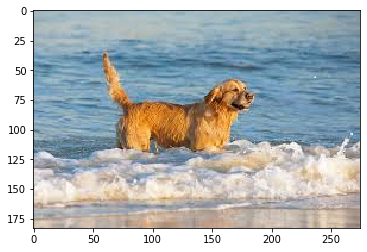

In [5]:
img_path='D:/images.jfif'
img=Image.open(img_path)
photo = extract_features(img_path, xception_model)
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

In [16]:
import keras.applications.vgg16 as vgg16
model1 = vgg16.VGG16()
model1.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Input image size: (1, 224, 224, 3)
Prediction scores:  (1, 1000)

Predictions:
0. hair_spray(0.175)
1. miniskirt(0.074)
2. wig(0.067)
3. pajama(0.047)
4. brassiere(0.039)
5. hand_blower(0.030)
6. sunglasses(0.026)
7. Band_Aid(0.021)
8. stethoscope(0.019)
9. maillot(0.019)


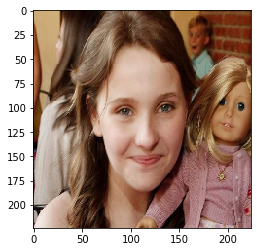

In [17]:
from keras.preprocessing import image
img_path='D:/z.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_arr = image.img_to_array(img)
x = np.expand_dims(img_arr, axis=0)  # The model only accepts batches so we add a dummy dimension.
x = vgg16.preprocess_input(x)  # The preprocessing should be the same that was used during training.

predictions = model1.predict(x)

label_predictions = vgg16.decode_predictions(predictions,top=10)

print('Input image size:', x.shape)
print('Prediction scores: ', predictions.shape)
print('\nPredictions:')
for (i, (category_id, name, probability)) in enumerate(label_predictions[0]):
    print('%d. %s(%.3f)' % (i, name, probability))
plt.imshow(np.asarray(img));

In [4]:
def extract_features1(image, model):
        image = image.resize((299,299))
        image = np.array(image)
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature
def caption(image):
    photo = extract_features1(image, xception_model)
    description = generate_desc(model, tokenizer, photo, max_length)
    return description

In [ ]:
#Imports Modules
import socket
import time
import io
import base64
from PIL import Image
from io import StringIO 
from PIL import ImageFile
import matplotlib.pyplot as plt
ImageFile.LOAD_TRUNCATED_IMAGES = True
import re
while(1):
    listensocket = socket.socket(socket.AF_INET,socket.SOCK_STREAM)
    Port = 8000
    maxConnections = 999
    IP = socket.gethostname() #Gets Hostname Of Current Macheine
    listensocket.bind(('',Port))
    listensocket.listen(maxConnections)
    print("Server started at " + IP + " on port " + str(Port))
    (clientsocket, address) = listensocket.accept()
    print("New connection made!")
    running = True
    message = clientsocket.recv(1024).decode() #Receives Message
    #print(message)

    arr = bytes(message, 'utf-8')
    altchars=b'+/'
    data = re.sub(rb'[^a-zA-Z0-9%s]+' % altchars, b'',arr)
    missing_padding = len(data) % 4
    if missing_padding:
        data += b'='* (4 - missing_padding)
    imgdata = base64.b64decode(data,altchars)
    image = Image.open(io.BytesIO(imgdata))
    plt.imshow(image)
               
    st=caption(image)
    print(st)

    del message
    (clientsocket, address) = listensocket.accept()
    st=st.encode()
    clientsocket.send(st)
    del st
    
    '''
    listensocket = socket.socket(socket.AF_INET,socket.SOCK_STREAM)
    Port = 8001
    listensocket.bind(('',Port))
    listensocket.listen(maxConnections)
    print("Server started at " + IP + " on port " + str(Port))
    (clientsocket, address) = listensocket.accept()
    print("New connection made!")
    #print("enter message")
    #s=input()
    st=st.encode()
    clientsocket.send(st)
    listensocket.close()
    '''

In [9]:
img_path='D:/z.jpg'
im=Image.open(img_path)
s=caption(im)
print(s)

start two girls are sitting on the grass end
